In [1]:
import pandas as pd
import numpy as np
#from pandas.appes import CategoricalDtype
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 0. 数据EDA

In [16]:
def read_data(filename, date_col = 'Date', type = 'excel'):
    print(f'------ {filename} ------')
    if type == 'excel': 
        df = pd.read_excel(filename)
    else:
        df = pd.read_csv(filename)
    
    df[date_col] = pd.to_datetime(df[date_col], format="%Y-%m-%d %H:%M:%S", errors='coerce', utc=True).dt.tz_localize(None)
    first_value = df[date_col].iloc[0] # 获取第一个值
    last_value = df[date_col].iloc[-1] # 获取最后一个值
    # print(df.columns)
    print(f"start time: {first_value} - last time: {last_value}")
    return df

# 定义正常生产
def is_producing(row):
    # 判断是否满足生产条件
    if (row['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'] >= 40 and 
        row['CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumEntranceTemperature'] >= 32 and 
        row['CG_Sheeting.CG_Sheeting.dbHMI.Scoring.SRV_CrossScore.rActualVelocityRPM'] > 100):
        return 'produce' # 生产
    else:
        return 'off' # 停机

In [32]:
spc =  read_data('GumWeight_20240822_20241008.xlsx','Date','excel')
spc.rename(columns={'Actual': 'Weight'}, inplace=True)

otdata = read_data('transformed_sorted_file.csv','TS','csv')

------ GumWeight_20240822_20241008.xlsx ------
start time: 2024-08-22 00:03:26 - last time: 2024-10-08 16:35:12
------ transformed_sorted_file.csv ------
start time: 2024-08-22 19:43:44 - last time: 2024-10-08 13:15:53


In [33]:
Temp_list = ['TS',
             'CG_Sheeting.CG_Sheeting.dbHMI.Scoring.SRV_CrossScore.rActualVelocityRPM', #横刀速度
             'CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp', # 挤压机出口胶温度
             'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumEntranceTemperature', # 冷辊入口胶温度
             'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rChillerSetpoint' #冷辊设定温度
            ] 

Temp_df = otdata[Temp_list]
Temp_df['Day'] = Temp_df['TS'].dt.date
# 应用筛选条件，新增'是否生产中'列
Temp_df['offperiod'] = Temp_df.apply(is_producing, axis=1)

para = Temp_df
para.fillna(method='ffill', inplace=True)
para = para.dropna()

# 将 TS 列重命名为 Date
para['TS'] = pd.to_datetime(para['TS']) + timedelta(minutes=1)
para.rename(columns={'TS': 'DataTime'}, inplace=True)
latest_dict = para.iloc[-1].to_dict()

/var/folders/xc/vyhdp_0d2ws5542x0phtr2240000gn/T/ipykernel_66056/4135080309.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temp_df['Day'] = Temp_df['TS'].dt.date
/var/folders/xc/vyhdp_0d2ws5542x0phtr2240000gn/T/ipykernel_66056/4135080309.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temp_df['offperiod'] = Temp_df.apply(is_producing, axis=1)
/var/folders/xc/vyhdp_0d2ws5542x0phtr2240000gn/T/ipykernel_66056/4135080309.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [34]:
# 筛选出 entry_type == 3 的行
entry_type_3 = spc[spc['entry_type'] == 3]

# 定义一个函数来处理每个 entry_type == 3 的行
def find_corresponding_length_width(row, df):
    # 1分钟内的条件，并且 Load 和 ID 一致
    condition_1min = (
        (df['Date'] > row['Date']) &  # Assuming 'Date' is your timestamp column
        (df['Date'] <= row['Date'] + pd.Timedelta(minutes=1)) &
        (df['entry_type'] == 2) &
        (df['Load'] == row['Load']) & 
        (df['Item_code'] == row['Item_code'])
    )
    corresponding_row_1min = df[condition_1min]
    
    if not corresponding_row_1min.empty:
        # 取找到的第一个对应的行
        corresponding_row = corresponding_row_1min.iloc[0]
    else:
        # 如果1分钟内没有找到，查找3分钟内的最近一条数据，Load 和 ID 也必须一致
        condition_3min = (
            (df['Date'] > row['Date']) &
            (df['Date'] <= row['Date'] + pd.Timedelta(minutes=3)) &
            (df['entry_type'] == 2) &
            (df['Load'] == row['Load']) & 
            (df['Item_code'] == row['Item_code'])
        )
        corresponding_row_3min = df[condition_3min]
        
        if not corresponding_row_3min.empty:
            # 取找到的最近一条对应的行
            corresponding_row = corresponding_row_3min.iloc[0]
        else:
            # 如果3分钟内也找不到，返回NA
            return pd.Series({
                'Date': row['Date'],
                'Item': row['Item'],
                'Weight': row['Weight'],
                'length_or_thickness': 'NA',
                'width_or_depth': 'NA',
                'Date2': 'NA'
            })
    
    return pd.Series({
        'Date': row['Date'],
        'Shift': row['Shift'],
        'Item': row['Item'],
        'Weight': row['Weight'],  # EntryType == 3 的 Weight 值
        'length_or_thickness': corresponding_row['length_or_thickness'],
        'width_or_depth': corresponding_row['width_or_depth'],
        'Date2': corresponding_row['Date']  # 对应找到的行的时间
    })

# 对 entry_type_3 数据应用函数，查找对应的数据行
result_df = entry_type_3.apply(lambda row: find_corresponding_length_width(row, spc), axis=1)
result_df

,Date,Date2,Item,Shift,Weight,length_or_thickness,width_or_depth
0,2024-08-22 00:03:26,2024-08-22 00:03:48,DMPE 绿箭原味薄荷,晚班,35.10,70.72,39.0
1,2024-08-22 00:03:31,2024-08-22 00:03:48,DMPE 绿箭原味薄荷,晚班,35.09,70.72,39.0
6,2024-08-22 00:10:06,2024-08-22 00:10:30,DMPE 绿箭原味薄荷,晚班,35.77,70.81,38.45
7,2024-08-22 00:10:10,2024-08-22 00:10:30,DMPE 绿箭原味薄荷,晚班,35.81,70.81,38.45
11,2024-08-22 00:17:44,2024-08-22 00:18:31,DMPE 绿箭原味薄荷,晚班,35.67,70.83,38.5
...,...,...,...,...,...,...,...
11925,2024-10-08 16:22:28,2024-10-08 16:22:53,DMPE 绿箭原味薄荷,中班,35.13,71.65,38.77
11926,2024-10-08 16:22:38,2024-10-08 16:22:53,DMPE 绿箭原味薄荷,中班,35.33,71.65,38.77
11929,2024-10-08 16:33:44,2024-10-08 16:34:44,DMPE 绿箭原味薄荷,中班,35.36,71.65,38.56
11930,2024-10-08 16:33:55,2024-10-08 16:34:44,DMPE 绿箭原味薄荷,中班,35.03,71.65,38.56


In [35]:
# 首先确保 Date 和 Date2 都是 datetime 类型
result_df['Date'] = pd.to_datetime(result_df['Date'])
result_df['Date2'] = pd.to_datetime(result_df['Date2'], errors='coerce')  # 遇到 'NA' 会处理为 NaT (Not a Time)

# 计算时间差
result_df['TimeDiff'] = result_df['Date2'] - result_df['Date']
result_df['Sugar'] = np.where(result_df['Item'].str[0].isin(['D', 'W', 'R']), 'Sugar', 'Sugarfree')
spc = result_df

# Step 1: Convert the 'duration' column to timedelta
spc['TimeDiff'] = pd.to_timedelta(spc['TimeDiff'], errors='coerce')
# Step 2: Convert timedelta to minutes by applying total_seconds() / 60
spc['TimeDiff_min'] = spc['TimeDiff'].apply(lambda x: x.total_seconds() / 60 if pd.notnull(x) else 0)

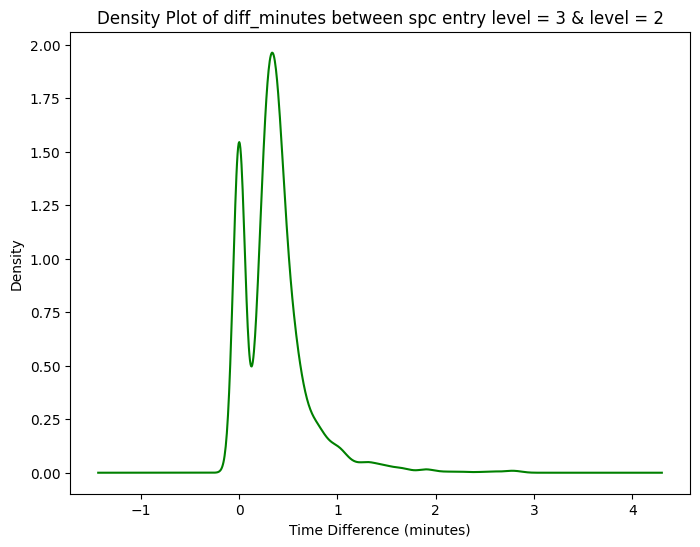

In [36]:
# Plotting the density of 'diff_minutes' after filtering
plt.figure(figsize=(8, 6))
spc['TimeDiff_min'].plot(kind='density', color='green')

# Labeling the plot
plt.title('Density Plot of diff_minutes between spc entry level = 3 & level = 2')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Density')

# Show the plot
plt.show()

In [41]:
# Step 3: 进行数据合并与计算
# 当在 spc 数据框中找到一个 Date 值时，它会在 para 数据框中查找等于或早于该 Date 值的最近一行进行匹配。
# 因此，如果 spc 中某个 Date 的值在 para 中找不到完全相同的 Date，则会回退到最接近但早于它的那个 Date 进行匹配。
spc.rename(columns={'Date': 'DataTime'}, inplace=True)
merge = pd.merge_asof(spc.sort_values('DataTime'),
                      para.sort_values('DataTime'), 
                      on='DataTime', direction='backward')
    
merge['Prev_Weight'] = merge['Weight'].shift(1)
merge = merge.dropna()

同时我们需要更加continuous 的data

In [43]:
# Step 0: 删除 spc 中早于 para 第一个时间戳的数据
spc.rename(columns={'DataTime': 'Date'}, inplace=True)
spc = spc[spc['Date'] >= '2024-08-22 19:43:00']

# Step 1: 生成完整的时间序列
# 根据 spc 中 'Date' 列的最小值和最大值，生成一个以秒为单位的完整时间序列
full_time_range = pd.date_range(start=spc['Date'].min(), 
                                end=spc['Date'].max(), 
                                freq='S')  # freq='S' 代表以秒为单位

# Step 2: 将 spc 的 'Date' 列重新索引到完整的时间序列上
spc_full = spc.set_index('Date').reindex(full_time_range)

# Step 3: 使用 ffill 填充缺失值
spc_full.fillna(method='ffill', inplace=True)

# 将索引 'Date' 变回列
spc_full.reset_index(inplace=True)
spc_full.rename(columns={'index': 'Date'}, inplace=True)

# 显示填充后的 spc_full
spc_full['Day'] = spc_full['Date'].dt.date
spc_full['Day_shift'] = spc_full['Day'].astype(str) + ' ' + spc_full['Shift']

/var/folders/xc/vyhdp_0d2ws5542x0phtr2240000gn/T/ipykernel_66056/3925619944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spc.rename(columns={'DataTime': 'Date'}, inplace=True)


In [45]:
# Perform merge using 'TS' from Temp_df_nona and 'Date' from weight_clean
join_result = pd.merge(
    para, 
    spc_full, 
    left_on=['DataTime'],  
    right_on=['Date'],  
    how='left' 
)

join_result2 = join_result[join_result['TimeDiff_min']> 0 ]

## 1. 温度范围需求

区分到SKU的threshold定位
SKU: DMPE. EBB, EXCW

In [83]:
join_result_produce = join_result2[join_result2['offperiod'] == 'produce']

# 查看一下每个口味的班次数量
merge_sku = join_result_produce.groupby(['Sugar','Item','Day_shift'])['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'].mean().reset_index()
merge_sku_shift = merge_sku.groupby(['Sugar','Item'])['Day_shift'].count().reset_index().sort_values(by='Day_shift', ascending=False) 
merge_sku_shift

,Sugar,Item,Day_shift
1,Sugar,DMPE 绿箭原味薄荷,35
2,Sugar,DMPY（绿箭金装薄荷）,14
11,Sugarfree,EXCW（益达西瓜-NCS）,14
13,Sugarfree,EXSM（益达沁凉薄荷-NCS）,8
10,Sugarfree,EBB（益达蓝莓-NCS）,7
17,Sugarfree,FVSS（FIVE酷酸草莓味-NCS）,7
6,Sugar,DMRR（真叶玫瑰薄荷）,6
18,Sugarfree,FVWM（FIVE奔涌西瓜-NCS）,5
14,Sugarfree,EXTP（益达热带水果-NCS）,4
8,Sugar,WSP（白箭留兰香薄荷）,4


目前仅有3个香型批次数量大于10

In [84]:
flavour_required = [
    'DMPE 绿箭原味薄荷',
    'DMPY（绿箭金装薄荷）', # 没有要求，但是班次达标
    'EXCW（益达西瓜-NCS）',
    'EBB（益达蓝莓-NCS）' # 班次数量尚未达标
]

sku_merge_df = join_result2[join_result2['Item'].isin(flavour_required)]
sku_merge_df.groupby(['Sugar','Item'])['Day_shift'].count().reset_index()

,Sugar,Item,Day_shift
0,Sugar,DMPE 绿箭原味薄荷,636526
1,Sugar,DMPY（绿箭金装薄荷）,236770
2,Sugarfree,EBB（益达蓝莓-NCS）,87289
3,Sugarfree,EXCW（益达西瓜-NCS）,173022


In [85]:
# Define the individual DataFrames by filtering sku_merge_df
DMPE_df = sku_merge_df[sku_merge_df['Item'] == 'DMPE 绿箭原味薄荷']
DMPY_df = sku_merge_df[sku_merge_df['Item'] == 'DMPY（绿箭金装薄荷）']
EXCW_df = sku_merge_df[sku_merge_df['Item'] == 'EXCW（益达西瓜-NCS）']
EBB_df = sku_merge_df[sku_merge_df['Item'] == 'EBB（益达蓝莓-NCS）']

### 1.1 查看DMPE 绿箭原味薄荷香型的threshold

In [90]:
df_dict = {
    'DMPE 绿箭原味薄荷': DMPE_df,
    'DMPY（绿箭金装薄荷）': DMPY_df,
    'EXCW（益达西瓜-NCS）': EXCW_df,
    'EBB（益达蓝莓-NCS）': EBB_df
}

# Define the 10-minute threshold
time_threshold = pd.Timedelta(minutes=10)

# Loop over each dataframe in the dictionary
for flavour, df in df_dict.items():
    df['DataTime'] = pd.to_datetime(df['DataTime'])
    
    # Step 1: Initialize empty lists to store data
    produce_data = []
    off_data = []

    # Step 2: Group by 'Item' and 'Day_shift', and calculate production and downtime periods
    for (item, Day_shift), group in df.groupby(['Item', 'Day_shift']):
        # Sort by timestamp
        group = group.sort_values('DataTime')

        current_state = None
        start_DataTime = None
        has_continuous_data = True
        
        for i, row in group.iterrows():
            if row['offperiod'] == 'produce':
                if current_state != 'produce':
                    if current_state == 'off' and start_DataTime is not None:
                        # Record downtime if continuous data exists
                        if has_continuous_data:
                            off_data.append({
                                'start_DataTime': start_DataTime,
                                'end_DataTime': prev_DataTime,
                                'off_duration': prev_DataTime - start_DataTime,
                                'sugar': prev_row['Sugar'],
                                'item': prev_row['Item'],
                                'Day_shift': prev_row['Day_shift']
                            })
                    # Switch to production
                    current_state = 'produce'
                    start_DataTime = row['DataTime']
                    has_continuous_data = True  # Reset for each new production period
                else:
                    # Check for continuity of data during production
                    if row['DataTime'] - prev_DataTime > time_threshold:
                        has_continuous_data = False

            elif row['offperiod'] == 'off':
                if current_state != 'off':
                    if current_state == 'produce' and start_DataTime is not None:
                        # Record production if continuous data exists
                        if has_continuous_data:
                            produce_data.append({
                                'start_DataTime': start_DataTime,
                                'end_DataTime': prev_DataTime,
                                'produce_duration': prev_DataTime - start_DataTime,
                                'sugar': prev_row['Sugar'],
                                'item': prev_row['Item'],
                                'Day_shift': prev_row['Day_shift']
                            })
                    # Switch to downtime
                    current_state = 'off'
                    start_DataTime = row['DataTime']
            prev_DataTime = row['DataTime']
            prev_row = row

        # Handle the last segment of each group
        if current_state == 'produce' and start_DataTime is not None:
            if has_continuous_data:
                produce_data.append({
                    'start_DataTime': start_DataTime,
                    'end_DataTime': prev_DataTime,
                    'produce_duration': prev_DataTime - start_DataTime,
                    'sugar': prev_row['Sugar'],
                    'item': prev_row['Item'],
                    'Day_shift': prev_row['Day_shift']
                })
        elif current_state == 'off' and start_DataTime is not None:
            off_data.append({
                'start_DataTime': start_DataTime,
                'end_DataTime': prev_DataTime,
                'off_duration': prev_DataTime - start_DataTime,
                'sugar': prev_row['Sugar'],
                'item': prev_row['Item'],
                'Day_shift': prev_row['Day_shift']
            })

    # Step 3: Create DataFrames for production and downtime data
    sku_code = flavour[:4].replace('（', '')
    globals()[f'produce_{sku_code}_df'] = pd.DataFrame(produce_data)
    globals()[f'off_{sku_code}_df'] = pd.DataFrame(off_data)


/var/folders/xc/vyhdp_0d2ws5542x0phtr2240000gn/T/ipykernel_66056/212000794.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DataTime'] = pd.to_datetime(df['DataTime'])
/var/folders/xc/vyhdp_0d2ws5542x0phtr2240000gn/T/ipykernel_66056/212000794.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DataTime'] = pd.to_datetime(df['DataTime'])
/var/folders/xc/vyhdp_0d2ws5542x0phtr2240000gn/T/ipykernel_66056/212000794.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [91]:
sku_produce_duration_df_list = [produce_DMPE_df, produce_DMPY_df, produce_EXCW_df, produce_EBB_df]

for df in sku_produce_duration_df_list:
    # Step 1: Convert the 'produce_duration' column to timedelta
    df['produce_duration'] = pd.to_timedelta(df['produce_duration'], errors='coerce')
    # Step 2: Convert timedelta to minutes by applying total_seconds() / 60
    df['produce_duration_min'] = df['produce_duration'].apply(lambda x: x.total_seconds() / 60 if pd.notnull(x) else 0)

/Users/yuanchenwang/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yuanchenwang/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


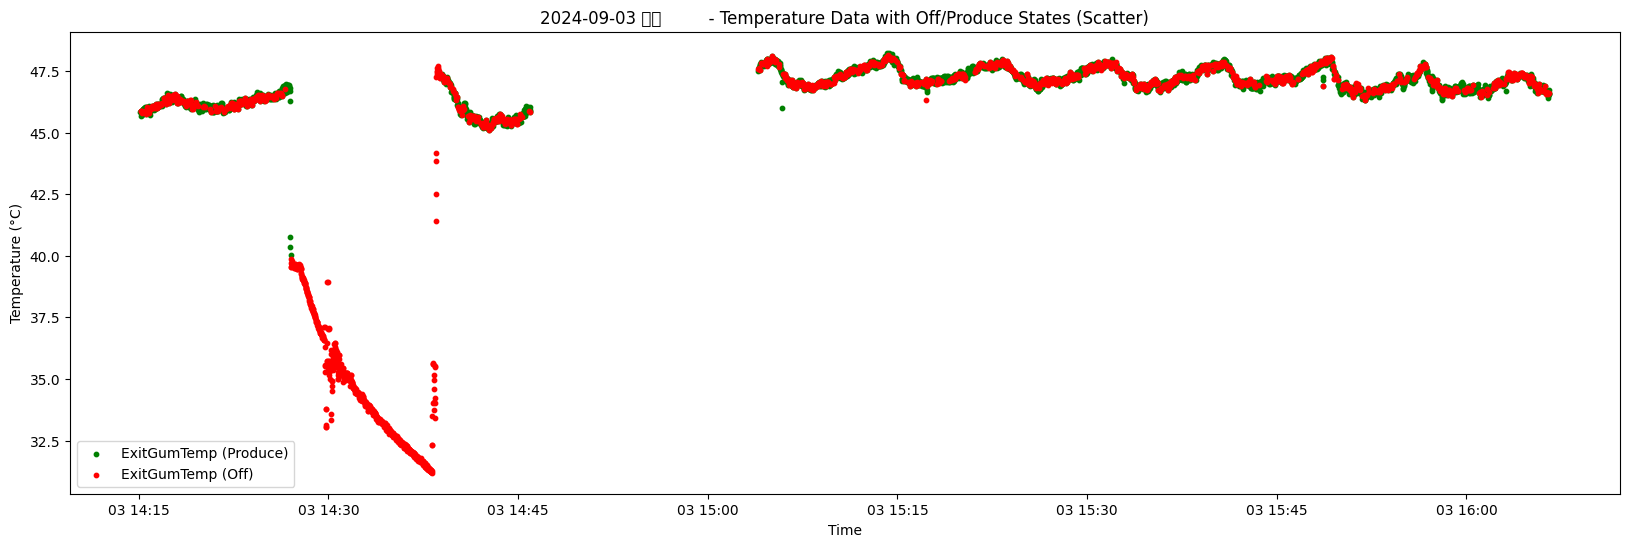

In [92]:
# 获取所有唯一的日期
all_dates = DMPE_df['Day_shift'].unique()
# 定义时间间隔阈值（0.5小时）
time_threshold = pd.Timedelta(hours=0.5)

# 遍历每个日期
for Day_shift in all_dates:
    if Day_shift[:12] == '2024-09-03 早':
        # 筛选出当前日期的数据
        filtered_data = DMPE_df[DMPE_df['Day_shift'] == Day_shift].copy()
        
        # 计算相邻数据点之间的时间差
        filtered_data['time_diff'] = filtered_data['DataTime'].diff()

        # 对于时间差大于1小时的行，将对应的温度列替换为 NaN，使图表线断开
        mask = filtered_data['time_diff'] > time_threshold
        filtered_data.loc[mask, ['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp']] = np.nan

        # 分开 "produce" 和 "off" 数据
        produce_data = filtered_data[filtered_data['offperiod'] == 'produce']
        off_data = filtered_data[filtered_data['offperiod'] == 'off']
        
        # 绘制图表
        plt.figure(figsize=(20, 6))
        
        # 绘制 "produce" 状态的散点图（绿色）
        plt.scatter(produce_data['DataTime'], produce_data['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'], color="green", label="ExitGumTemp (Produce)", s=10)
        # 绘制 "off" 状态的散点图（红色）
        plt.scatter(off_data['DataTime'], off_data['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'], color="red", label="ExitGumTemp (Off)", s=10)
        
        # 设置标题、标签和图例
        plt.title(f"{Day_shift} - Temperature Data with Off/Produce States (Scatter)")
        plt.xlabel("Time")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        
        # 显示图表
        plt.show()


In [77]:
DMPE_df_produce_duration_final = produce_DMPE_df.sort_values(by=['produce_duration_min'],ascending =False)
DMPE_df_produce_duration_final

,start_DataTime,end_DataTime,produce_duration,sugar,item,Day_shift,produce_duration_min
12,2024-08-29 17:12:16,2024-08-29 17:41:40,0 days 00:29:24,Sugar,DMPE 绿箭原味薄荷,2024-08-29 中班,29.400000
400,2024-08-30 21:33:00,2024-08-30 21:50:02,0 days 00:17:02,Sugar,DMPE 绿箭原味薄荷,2024-08-30 中班,17.033333
378,2024-08-30 19:46:01,2024-08-30 20:03:00,0 days 00:16:59,Sugar,DMPE 绿箭原味薄荷,2024-08-30 中班,16.983333
392,2024-08-30 20:55:00,2024-08-30 21:05:58,0 days 00:10:58,Sugar,DMPE 绿箭原味薄荷,2024-08-30 中班,10.966667
253,2024-08-29 20:53:05,2024-08-29 21:03:03,0 days 00:09:58,Sugar,DMPE 绿箭原味薄荷,2024-08-29 中班,9.966667
...,...,...,...,...,...,...,...
5810,2024-09-10 16:20:26,2024-09-10 16:20:26,0 days 00:00:00,Sugar,DMPE 绿箭原味薄荷,2024-09-10 中班,0.000000
30394,2024-09-26 04:39:41,2024-09-26 04:39:41,0 days 00:00:00,Sugar,DMPE 绿箭原味薄荷,2024-09-26 晚班,0.000000
5807,2024-09-10 16:20:11,2024-09-10 16:20:11,0 days 00:00:00,Sugar,DMPE 绿箭原味薄荷,2024-09-10 中班,0.000000
41897,2024-10-07 11:59:24,2024-10-07 11:59:24,0 days 00:00:00,Sugar,DMPE 绿箭原味薄荷,2024-10-07 早班,0.000000


In [94]:
DMPE_df_produce_duration_final2 = DMPE_df_produce_duration_final[DMPE_df_produce_duration_final['produce_duration_min'] > 1]
DMPE_df_produce_duration_final3 = DMPE_df_produce_duration_final2.groupby(['sugar','item','Day_shift'])['produce_duration_min'].mean().reset_index().sort_values(by=['produce_duration_min'],ascending = False)

DMPE_df_top5_shift_list= DMPE_df_produce_duration_final3['Day_shift'].head(5).tolist()
print(DMPE_df_top5_shift_list)
DMPE_df_produce_duration_final3

['2024-09-10 中班        ', '2024-09-09 晚班        ', '2024-09-27 早班        ', '2024-10-07 早班        ', '2024-09-18 中班        ']


,sugar,item,Day_shift,produce_duration_min
8,Sugar,DMPE 绿箭原味薄荷,2024-09-10 中班,8.820833
7,Sugar,DMPE 绿箭原味薄荷,2024-09-09 晚班,7.966667
18,Sugar,DMPE 绿箭原味薄荷,2024-09-27 早班,6.908333
19,Sugar,DMPE 绿箭原味薄荷,2024-10-07 早班,6.712500
12,Sugar,DMPE 绿箭原味薄荷,2024-09-18 中班,6.533333
11,Sugar,DMPE 绿箭原味薄荷,2024-09-16 晚班,5.816667
14,Sugar,DMPE 绿箭原味薄荷,2024-09-19 早班,4.994444
20,Sugar,DMPE 绿箭原味薄荷,2024-10-08 早班,4.533333
4,Sugar,DMPE 绿箭原味薄荷,2024-08-31 晚班,4.103333
2,Sugar,DMPE 绿箭原味薄荷,2024-08-30 晚班,3.653333


In [95]:
#把这最稳定的5个班次的所有挤压机出口温度从低到高排列。我们找到20% percentile和80% percentile。我们认为，生成最稳的天数中，温度比较中间的区域，是较好的温度
# 使用 isin() 筛选 'Day' 列的值是否在 sugar_top_list 中
DMPE_produce_join_df = DMPE_df[(DMPE_df['offperiod'] == 'produce') & (DMPE_df['Day_shift'].isin(DMPE_df_top5_shift_list))]

# 获取挤压机出口温度列
DMPE_temperatures = DMPE_produce_join_df['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'].sort_values()
DMPE_temperatures

807186     40.000000
807178     40.023150
807191     40.034720
2190357    40.057870
807198     40.104164
             ...    
1492180    50.717590
1492177    50.729164
1492179    50.740740
1492197    50.752316
1492199    50.798610
Name: CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp, Length: 52753, dtype: float64

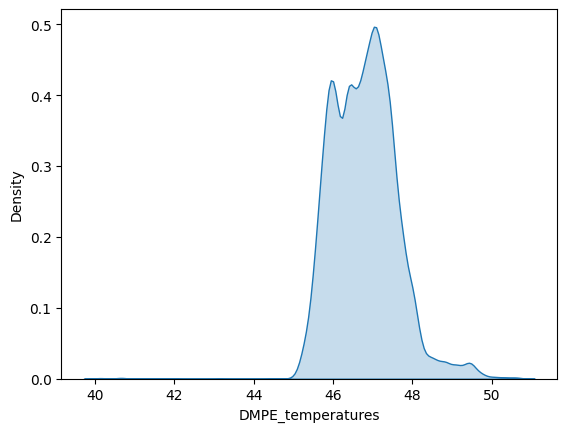

count    52753.000000
mean        46.779833
std          0.834593
min         40.000000
25%         46.145836
50%         46.770836
75%         47.291664
max         50.798610
Name: CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp, dtype: float64


In [96]:
# 绘制密度图
sns.kdeplot(DMPE_temperatures, fill=True)
# 添加标题和标签
plt.xlabel('DMPE_temperatures')
plt.ylabel('Density')
# 显示图形
plt.show()

print(DMPE_temperatures.describe())

In [81]:
# 对温度进行排序
sorted_temperatures = DMPE_temperatures.sort_values()

# 计算 20% 和 80% 分位数
percentile_20 = sorted_temperatures.quantile(0.2)
percentile_80 = sorted_temperatures.quantile(0.8)

# 显示结果
print(f"20th percentile: {percentile_20}")
print(f"80th percentile: {percentile_80}")

# 计算 10% 和 90% 分位数
percentile_10 = sorted_temperatures.quantile(0.1)
percentile_90 = sorted_temperatures.quantile(0.9)

# 显示结果
print(f"10th percentile: {percentile_10}")
print(f"90th percentile: {percentile_90}")

# 计算 5% 和 95% 分位数
percentile_5 = sorted_temperatures.quantile(0.05)
percentile_95 = sorted_temperatures.quantile(0.95)

# 显示结果
print(f"5th percentile: {percentile_5}")
print(f"95th percentile: {percentile_95}")

20th percentile: 46.319447
80th percentile: 47.41898
10th percentile: 46.08796
90th percentile: 47.67361
5th percentile: 45.91435
95th percentile: 47.939816


### 1.2 查看DMPY（绿箭金装薄荷）香型的threshold

C:\Users\Admin\AppData\Local\Temp\ipykernel_1168\2558454176.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DMPY_df['offperiod'] = DMPY_df.apply(is_producing, axis=1)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


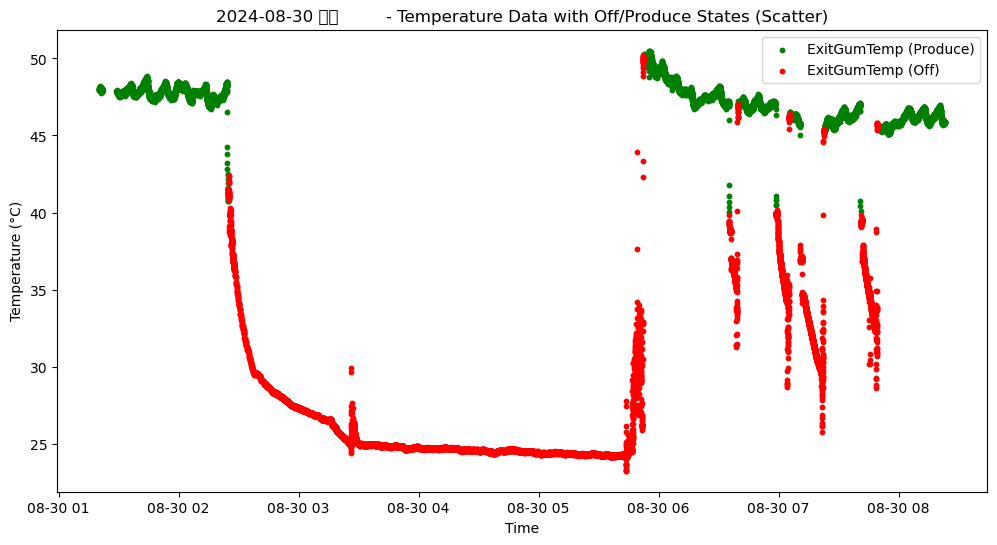

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


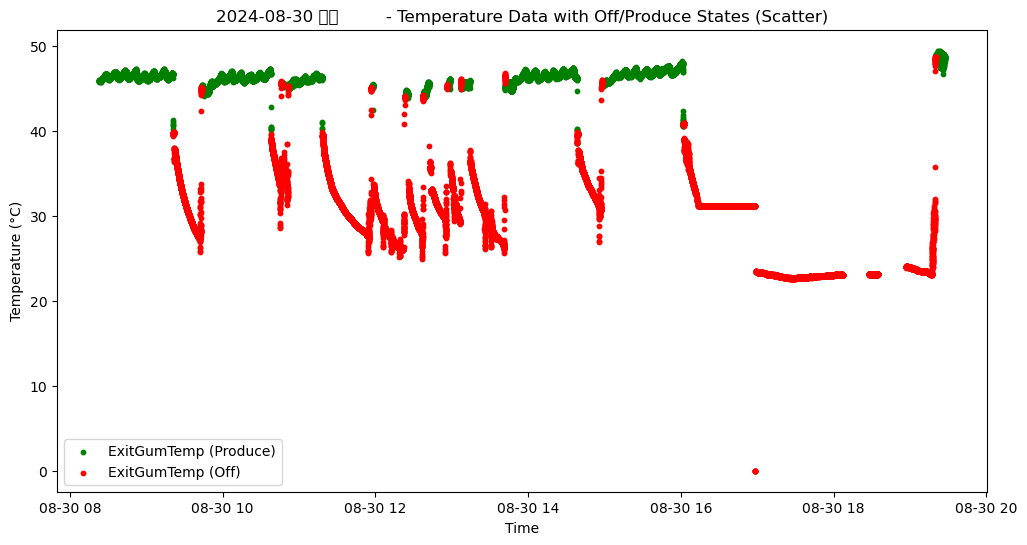

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


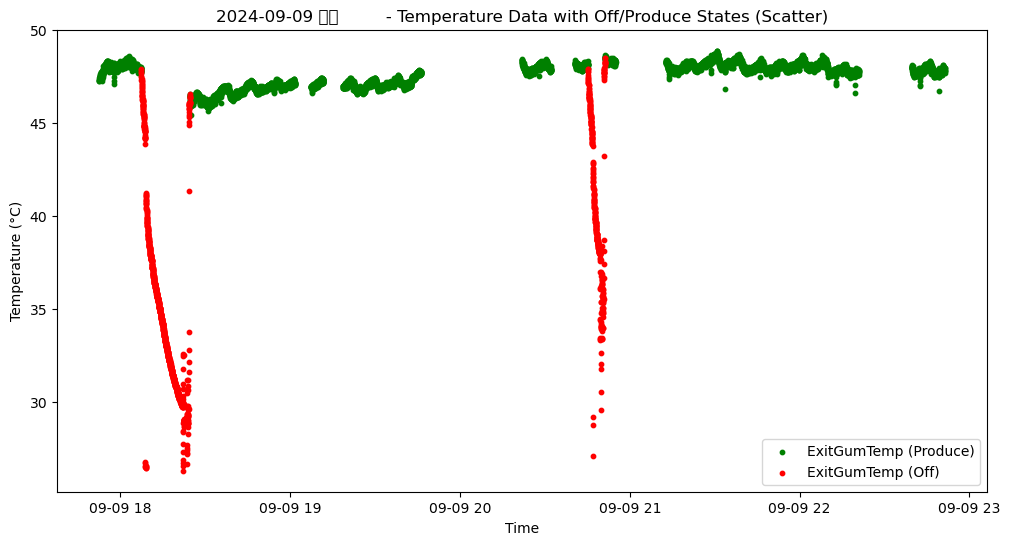

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


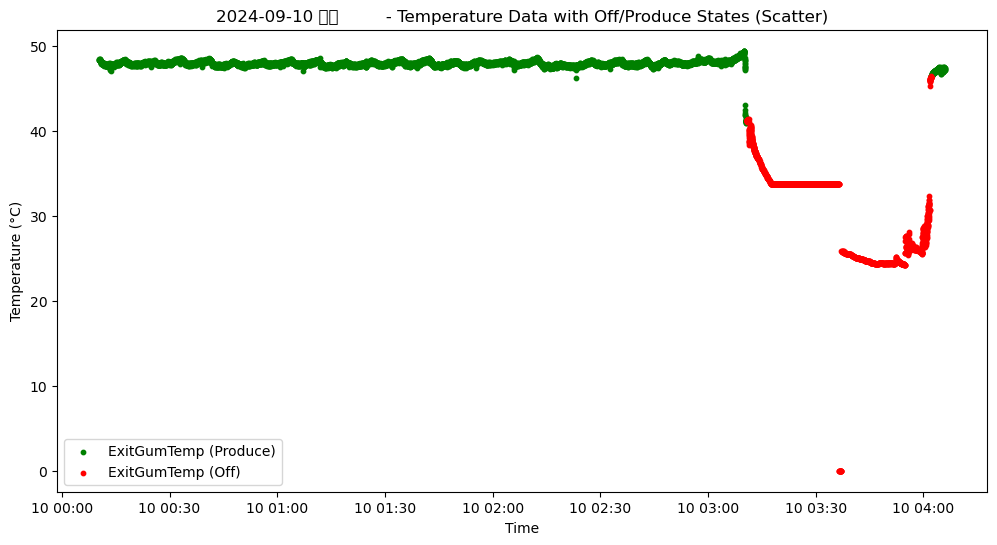

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


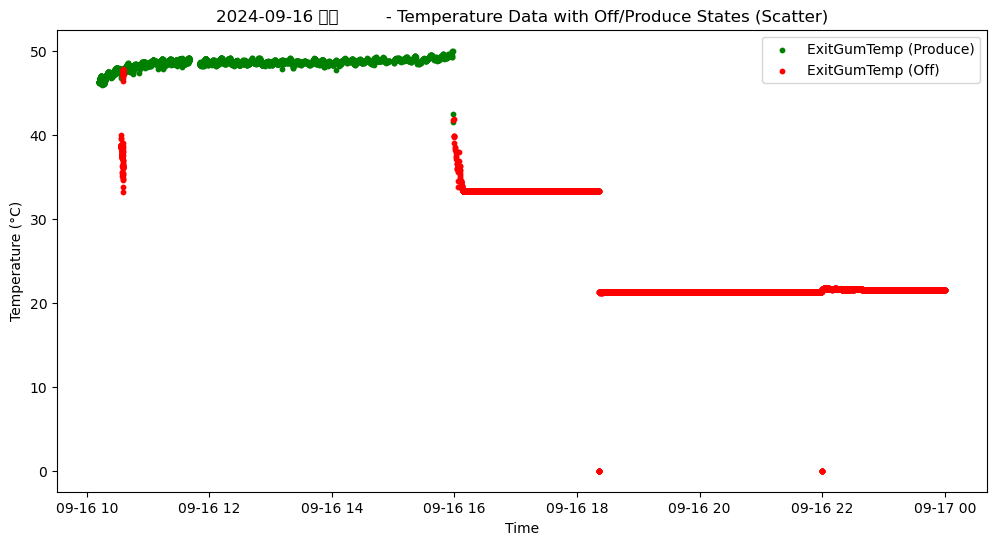

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


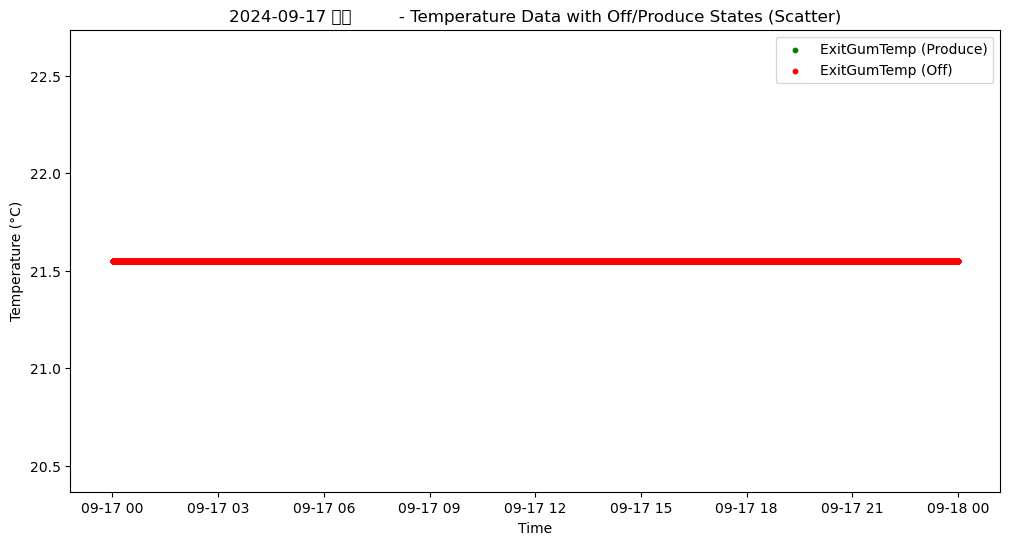

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


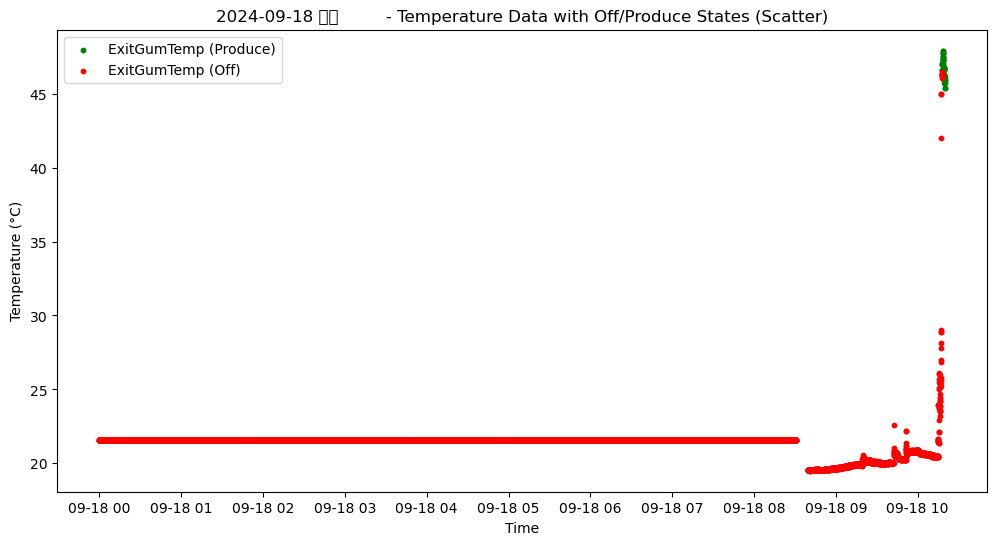

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


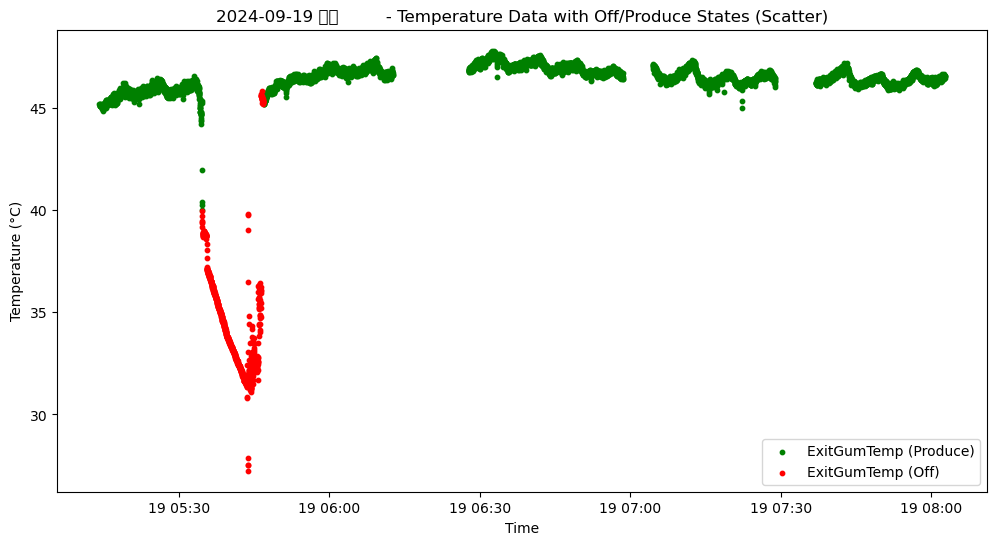

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


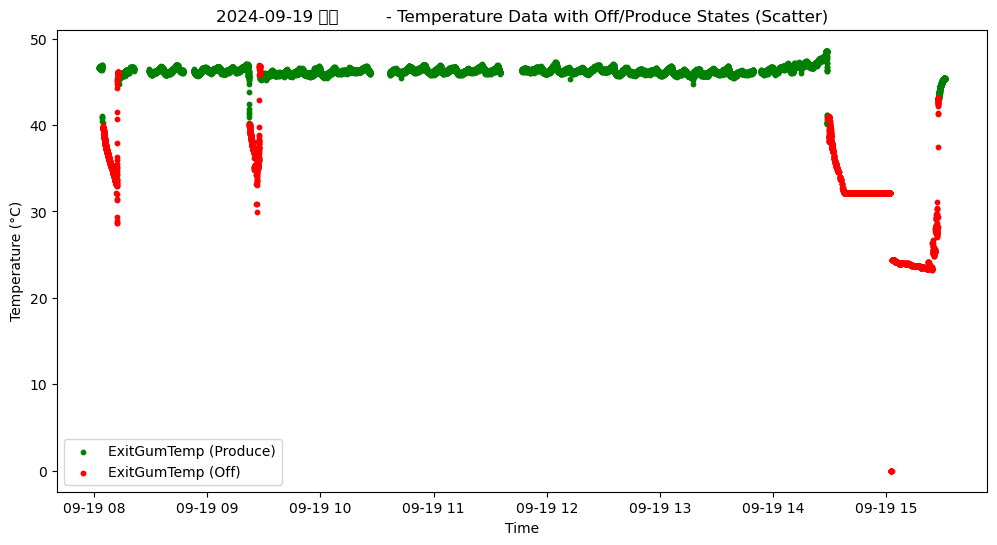

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


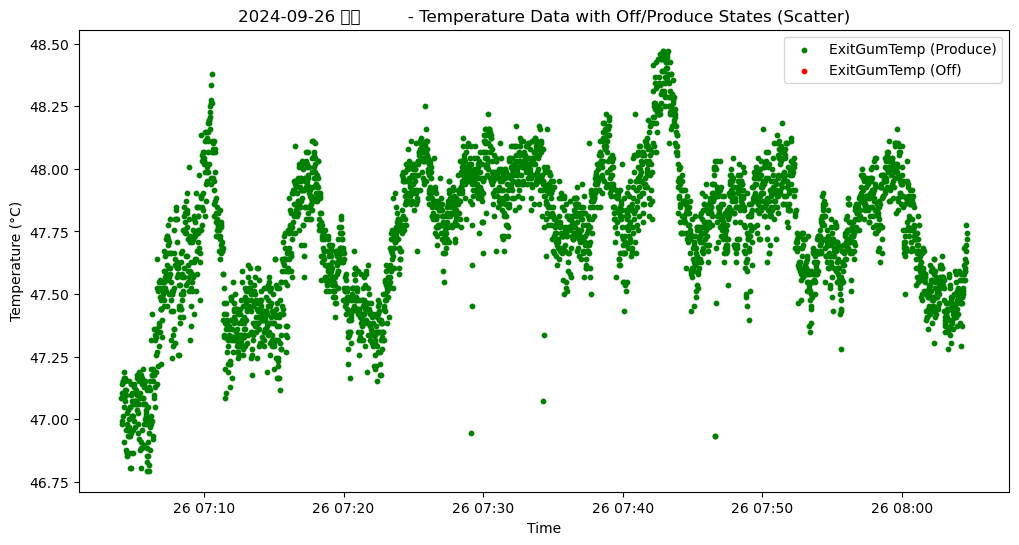

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


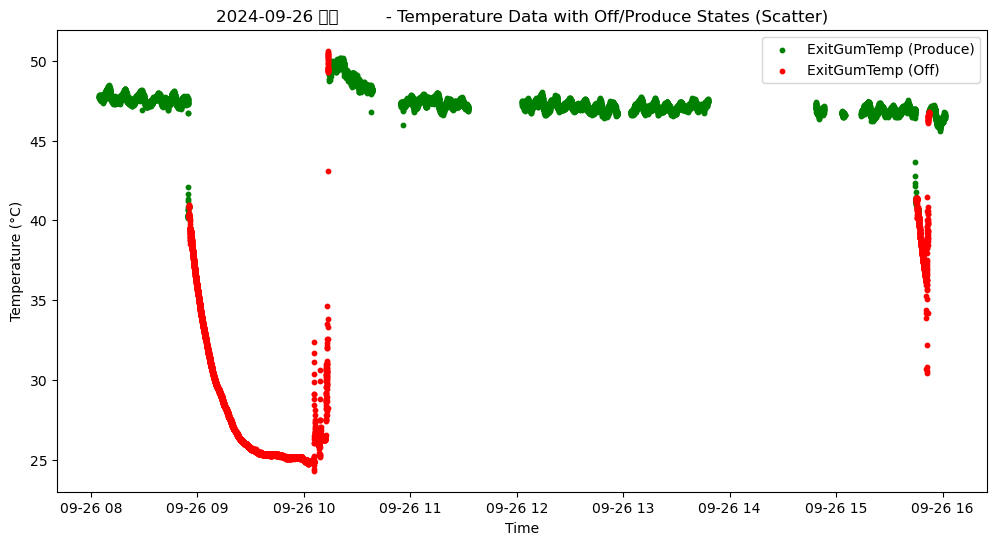

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


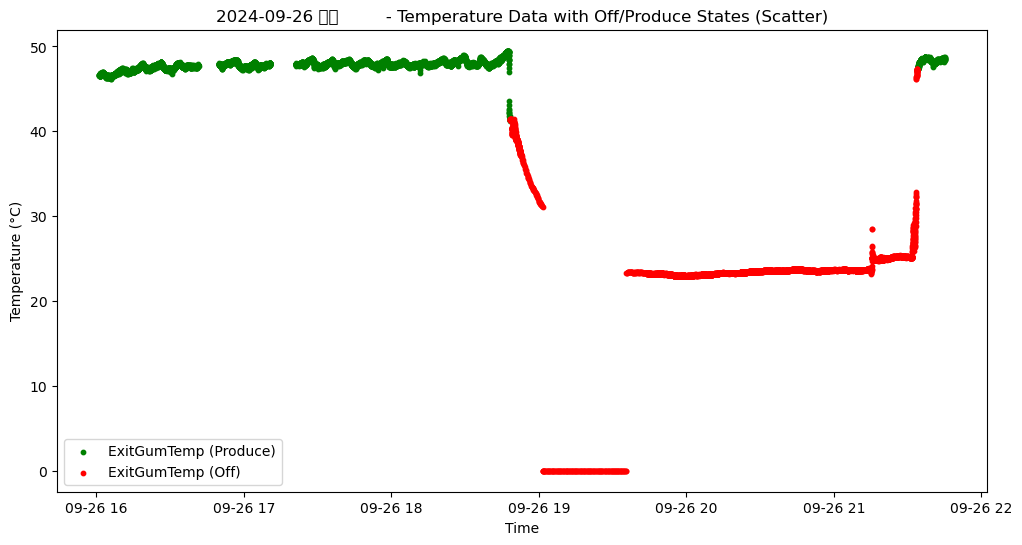

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


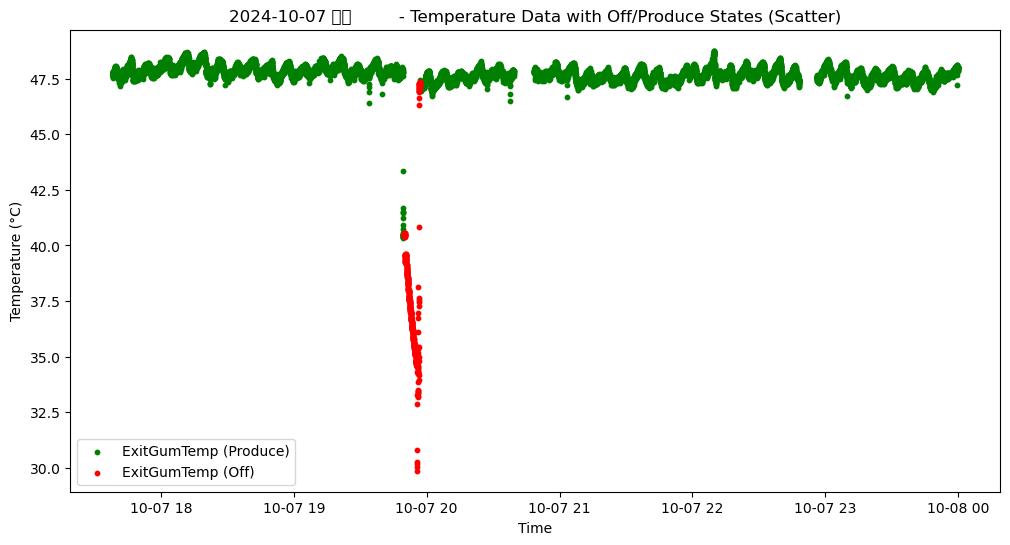

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


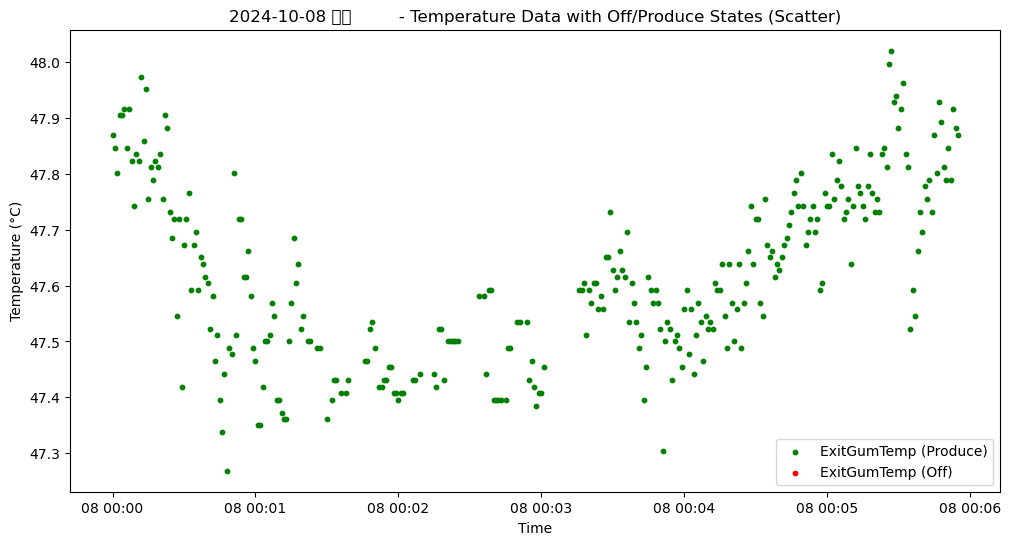

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


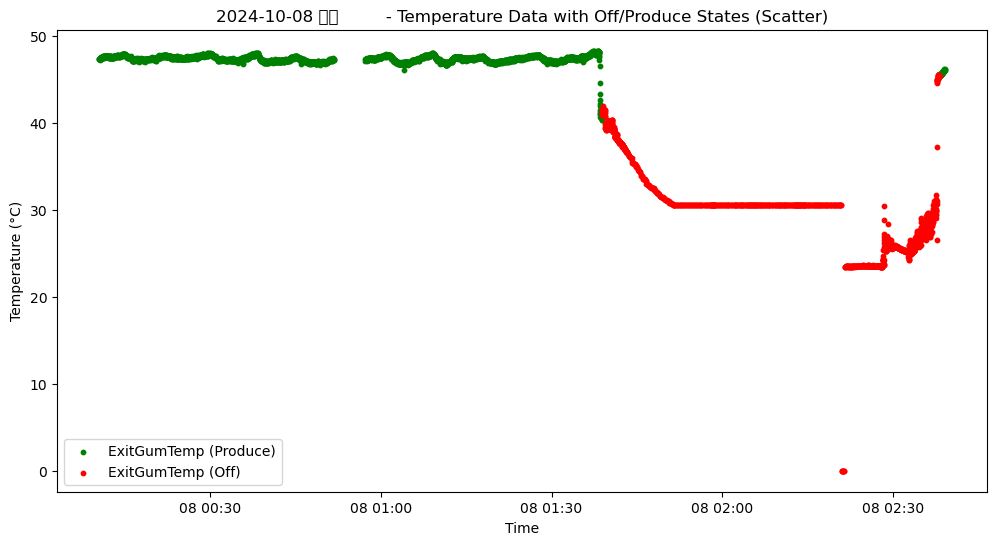

In [84]:
# Apply the is_producing function to determine the offperiod
DMPY_df['offperiod'] = DMPY_df.apply(is_producing, axis=1)

# 确保 'Day_shift' 列是日期时间格式
# DMPY_df['Day_shift'] = pd.to_datetime(DMPY_df['Day_shift'])

# 获取所有唯一的日期
all_dates = DMPY_df['Day_shift'].unique()

# 定义时间间隔阈值（0.5小时）
time_threshold = pd.Timedelta(hours=0.5)

# 遍历每个日期
for Day_shift in all_dates:
    # 筛选出当前日期的数据
    filtered_data = DMPY_df[DMPY_df['Day_shift'] == Day_shift].copy()
    
    # 计算相邻数据点之间的时间差
    filtered_data['time_diff'] = filtered_data['DataTime'].diff()

    # 对于时间差大于1小时的行，将对应的温度列替换为 NaN，使图表线断开
    mask = filtered_data['time_diff'] > time_threshold
    filtered_data.loc[mask, ['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp']] = np.nan

    # 分开 "produce" 和 "off" 数据
    produce_data = filtered_data[filtered_data['offperiod'] == 'produce']
    off_data = filtered_data[filtered_data['offperiod'] == 'off']
    
    # 绘制图表
    plt.figure(figsize=(12, 6))
    
    # 绘制 "produce" 状态的散点图（绿色）
    plt.scatter(produce_data['DataTime'], produce_data['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'], color="green", label="ExitGumTemp (Produce)", s=10)
    
    # 绘制 "off" 状态的散点图（红色）
    plt.scatter(off_data['DataTime'], off_data['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'], color="red", label="ExitGumTemp (Off)", s=10)
    
    # 设置标题、标签和图例
    plt.title(f"{Day_shift} - Temperature Data with Off/Produce States (Scatter)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    
    # 显示图表
    plt.show()

In [85]:
DMPY_df_produce_duration_final = produce_DMPY_df.sort_values(by=['produce_duration_min'],ascending =False)
DMPY_df_produce_duration_final

,start_DataTime,end_DataTime,produce_duration,sugar,item,Day_shift,produce_duration_min
35,2024-10-07 19:56:55,2024-10-07 23:59:59,0 days 04:03:04,Sugar,DMPY（绿箭金装薄荷）,2024-10-07 中班,243.066667
19,2024-09-10 00:10:25,2024-09-10 03:10:45,0 days 03:00:20,Sugar,DMPY（绿箭金装薄荷）,2024-09-10 晚班,180.333333
34,2024-10-07 17:38:06,2024-10-07 19:49:38,0 days 02:11:32,Sugar,DMPY（绿箭金装薄荷）,2024-10-07 中班,131.533333
37,2024-10-08 00:10:27,2024-10-08 01:38:52,0 days 01:28:25,Sugar,DMPY（绿箭金装薄荷）,2024-10-08 晚班,88.416667
24,2024-09-19 08:12:44,2024-09-19 09:22:14,0 days 01:09:30,Sugar,DMPY（绿箭金装薄荷）,2024-09-19 早班,69.500000
12,2024-08-30 01:20:21,2024-08-30 02:24:50,0 days 01:04:29,Sugar,DMPY（绿箭金装薄荷）,2024-08-30 晚班,64.483333
10,2024-08-30 14:58:07,2024-08-30 16:01:57,0 days 01:03:50,Sugar,DMPY（绿箭金装薄荷）,2024-08-30 早班,63.833333
33,2024-09-26 07:04:05,2024-09-26 08:04:39,0 days 01:00:34,Sugar,DMPY（绿箭金装薄荷）,2024-09-26 晚班,60.566667
0,2024-08-30 08:23:04,2024-08-30 09:21:02,0 days 00:57:58,Sugar,DMPY（绿箭金装薄荷）,2024-08-30 早班,57.966667
9,2024-08-30 13:41:56,2024-08-30 14:38:26,0 days 00:56:30,Sugar,DMPY（绿箭金装薄荷）,2024-08-30 早班,56.500000


In [86]:
DMPY_df_produce_duration_final2 = DMPY_df_produce_duration_final[DMPY_df_produce_duration_final['produce_duration_min'] > 1]
DMPY_df_produce_duration_final3 = DMPY_df_produce_duration_final2.groupby(['sugar','item','Day_shift'])['produce_duration_min'].mean().reset_index().sort_values(by=['produce_duration_min'],ascending = False)

DMPY_df_top5_shift_list= DMPY_df_produce_duration_final3['Day_shift'].head(5).tolist()
print(DMPY_df_top5_shift_list)
DMPY_df_produce_duration_final3

['2024-10-07 中班        ', '2024-09-10 晚班        ', '2024-10-08 晚班        ', '2024-09-26 晚班        ', '2024-08-30 晚班        ']


,sugar,item,Day_shift,produce_duration_min
11,Sugar,DMPY（绿箭金装薄荷）,2024-10-07 中班,187.300000
3,Sugar,DMPY（绿箭金装薄荷）,2024-09-10 晚班,92.041667
13,Sugar,DMPY（绿箭金装薄荷）,2024-10-08 晚班,88.416667
10,Sugar,DMPY（绿箭金装薄荷）,2024-09-26 晚班,60.566667
1,Sugar,DMPY（绿箭金装薄荷）,2024-08-30 晚班,30.416667
9,Sugar,DMPY（绿箭金装薄荷）,2024-09-26 早班,29.691667
6,Sugar,DMPY（绿箭金装薄荷）,2024-09-19 早班,24.844444
0,Sugar,DMPY（绿箭金装薄荷）,2024-08-30 早班,23.880556
4,Sugar,DMPY（绿箭金装薄荷）,2024-09-16 早班,21.033333
7,Sugar,DMPY（绿箭金装薄荷）,2024-09-19 晚班,20.466667


In [87]:
#把这最稳定的5个班次的所有挤压机出口温度从低到高排列。我们找到20% percentile和80% percentile。我们认为，生成最稳的天数中，温度比较中间的区域，是较好的温度
# 使用 isin() 筛选 'Day' 列的值是否在 sugar_top_list 中
DMPY_produce_join_df = DMPY_df[(DMPY_df['offperiod'] == 'produce') & (DMPY_df['Day_shift'].isin(DMPY_df_top5_shift_list))]

# 获取挤压机出口温度列
DMPY_temperatures = DMPY_produce_join_df['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'].sort_values()
DMPY_temperatures

483619     40.011574
487560     40.104164
2200486    40.324074
2221392    40.324074
483618     40.347220
             ...    
481227     50.416664
481243     50.439816
481231     50.486110
481229     50.497684
481249     50.497684
Name: CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp, Length: 51679, dtype: float64

C:\Users\Admin\AppData\Local\Temp\ipykernel_1168\2851795533.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(DMPY_temperatures, shade=True)


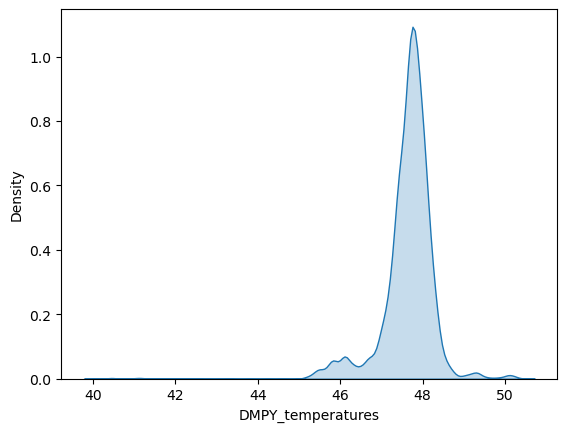

count    51679.000000
mean        47.634030
std          0.669464
min         40.011574
25%         47.442130
50%         47.719910
75%         47.962960
max         50.497684
Name: CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp, dtype: float64


In [88]:
# 绘制密度图
sns.kdeplot(DMPY_temperatures, shade=True)
# 添加标题和标签
plt.xlabel('DMPY_temperatures')
plt.ylabel('Density')
# 显示图形
plt.show()

print(DMPY_temperatures.describe())

In [89]:
# 对温度进行排序
sorted_temperatures = DMPY_temperatures.sort_values()

# 计算 20% 和 80% 分位数
percentile_20 = sorted_temperatures.quantile(0.2)
percentile_80 = sorted_temperatures.quantile(0.8)

# 显示结果
print(f"20th percentile: {percentile_20}")
print(f"80th percentile: {percentile_80}")

# 计算 10% 和 90% 分位数
percentile_10 = sorted_temperatures.quantile(0.1)
percentile_90 = sorted_temperatures.quantile(0.9)

# 显示结果
print(f"10th percentile: {percentile_10}")
print(f"90th percentile: {percentile_90}")

# 计算 5% 和 95% 分位数
percentile_5 = sorted_temperatures.quantile(0.05)
percentile_95 = sorted_temperatures.quantile(0.95)

# 显示结果
print(f"5th percentile: {percentile_5}")
print(f"95th percentile: {percentile_95}")

20th percentile: 47.36111
80th percentile: 48.020836
10th percentile: 47.02546
90th percentile: 48.18287
5th percentile: 46.30787
95th percentile: 48.333336


### 1.3 查看EXCW（益达西瓜-NCS）香型的threshold

In [90]:
produce_EXCW_df

,start_DataTime,end_DataTime,produce_duration,sugar,item,Day_shift,produce_duration_min
0,2024-08-26 16:04:01,2024-08-26 17:58:04,0 days 01:54:03,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,114.050000
1,2024-08-26 18:08:29,2024-08-26 19:39:58,0 days 01:31:29,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,91.483333
2,2024-08-26 21:15:43,2024-08-26 23:19:34,0 days 02:03:51,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,123.850000
3,2024-08-26 23:30:28,2024-08-26 23:30:53,0 days 00:00:25,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,0.416667
4,2024-08-26 23:37:27,2024-08-26 23:59:59,0 days 00:22:32,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,22.533333
5,2024-08-26 11:04:38,2024-08-26 11:09:04,0 days 00:04:26,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 早班,4.433333
6,2024-08-26 11:16:05,2024-08-26 11:16:46,0 days 00:00:41,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 早班,0.683333
7,2024-08-26 11:21:09,2024-08-26 11:26:02,0 days 00:04:53,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 早班,4.883333
8,2024-08-26 11:30:31,2024-08-26 11:30:35,0 days 00:00:04,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 早班,0.066667
9,2024-08-26 11:33:34,2024-08-26 13:27:08,0 days 01:53:34,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 早班,113.566667


C:\Users\Admin\AppData\Local\Temp\ipykernel_1168\1038050878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EXCW_df['offperiod'] = EXCW_df.apply(is_producing, axis=1)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


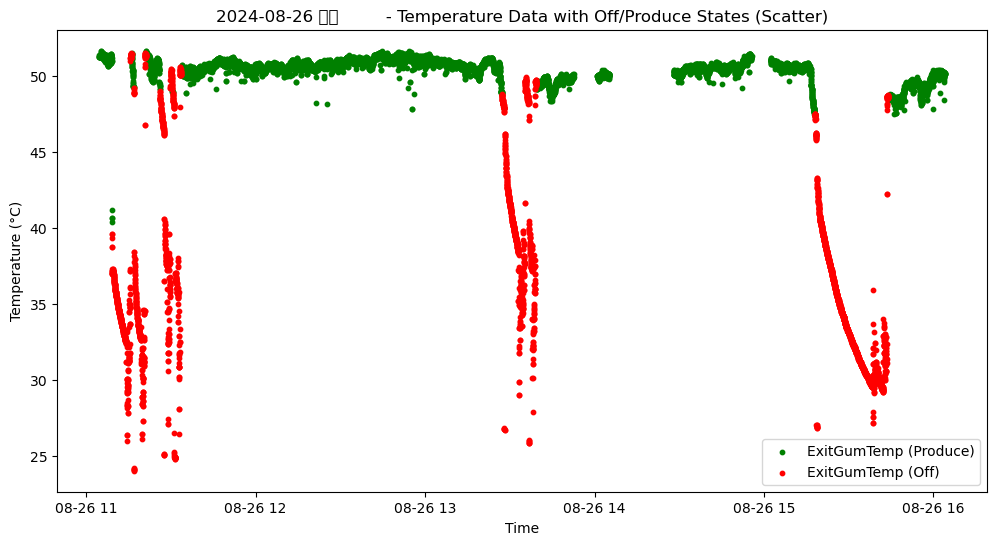

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


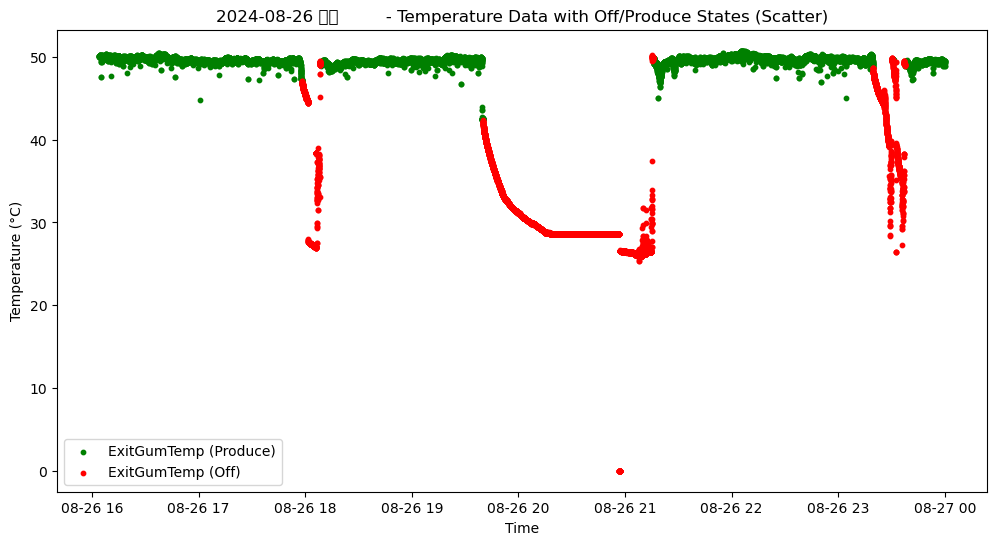

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


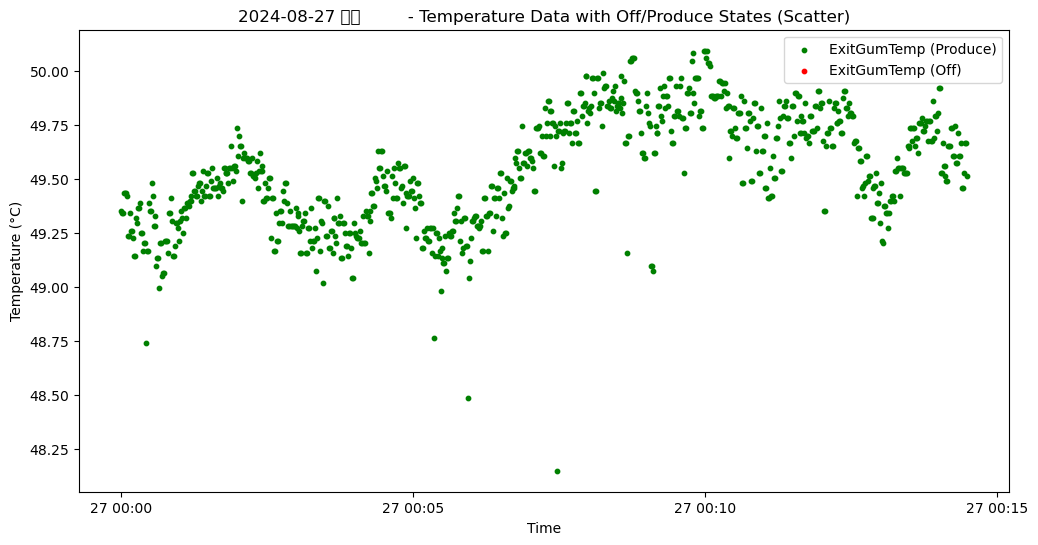

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


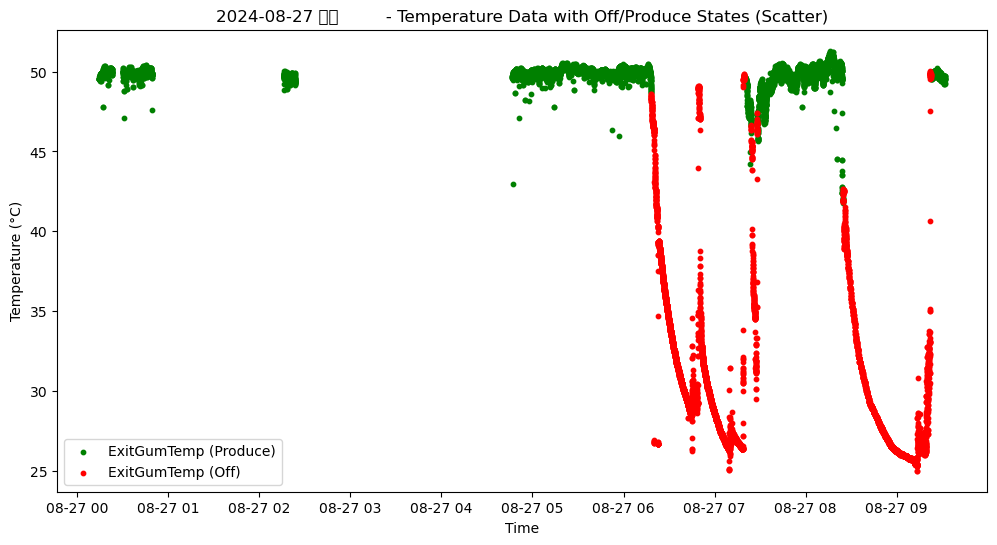

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


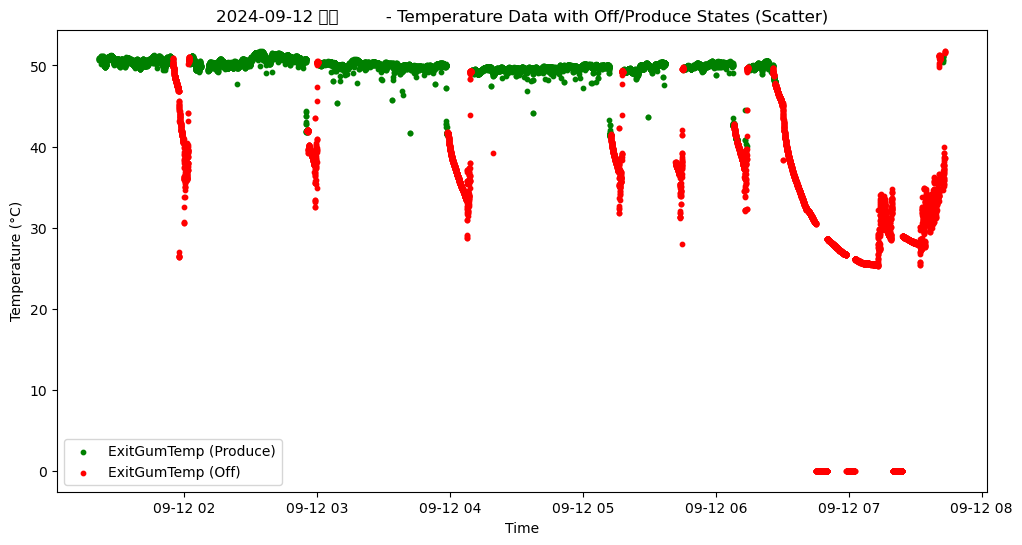

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


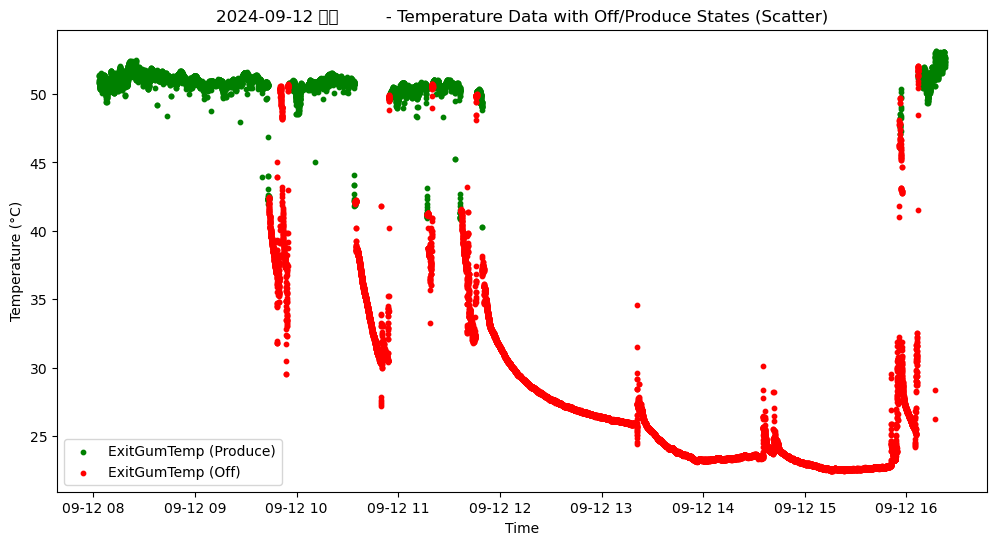

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


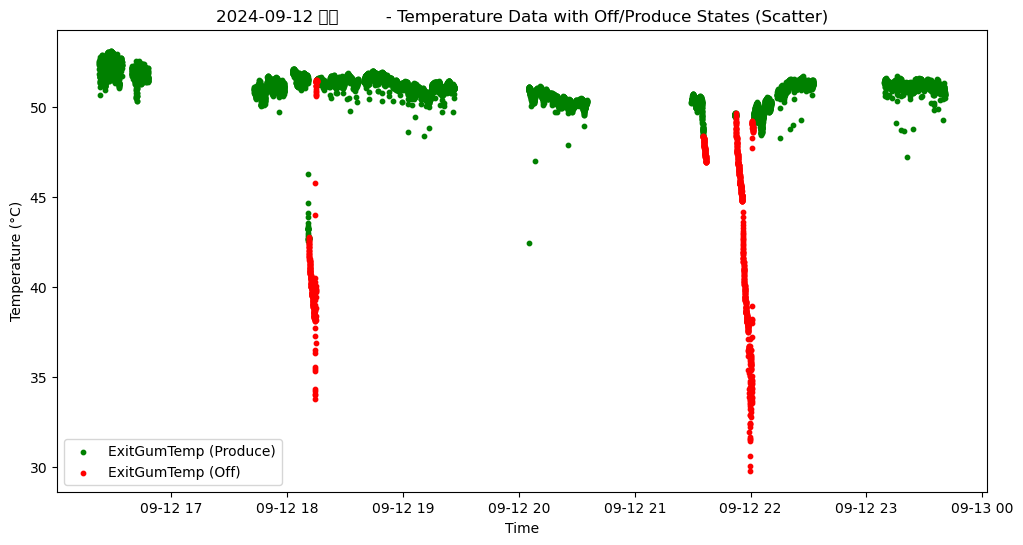

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


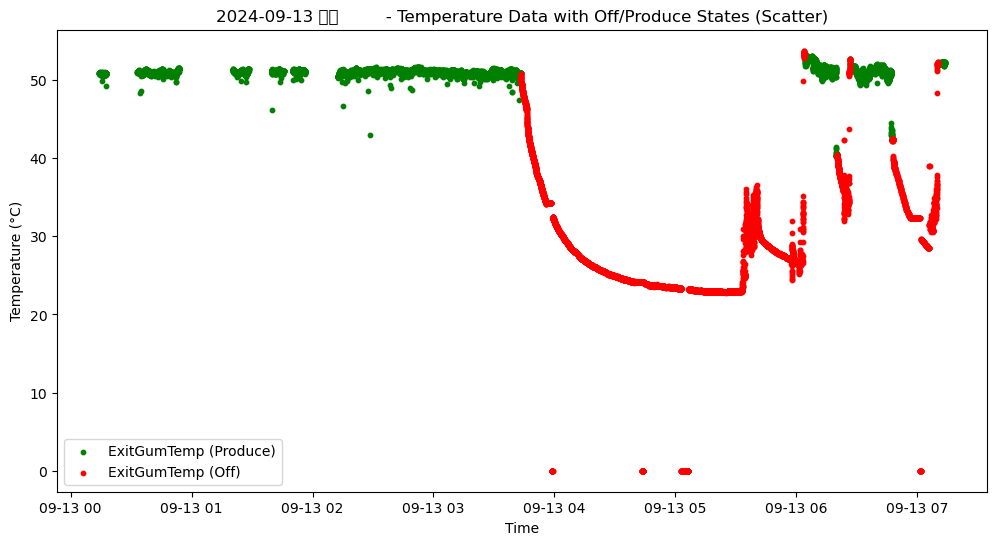

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


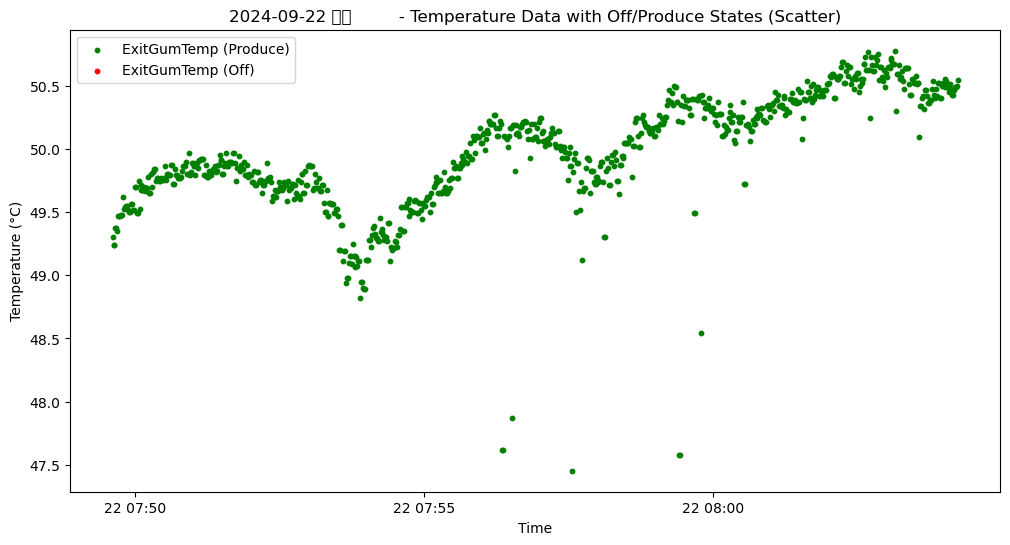

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


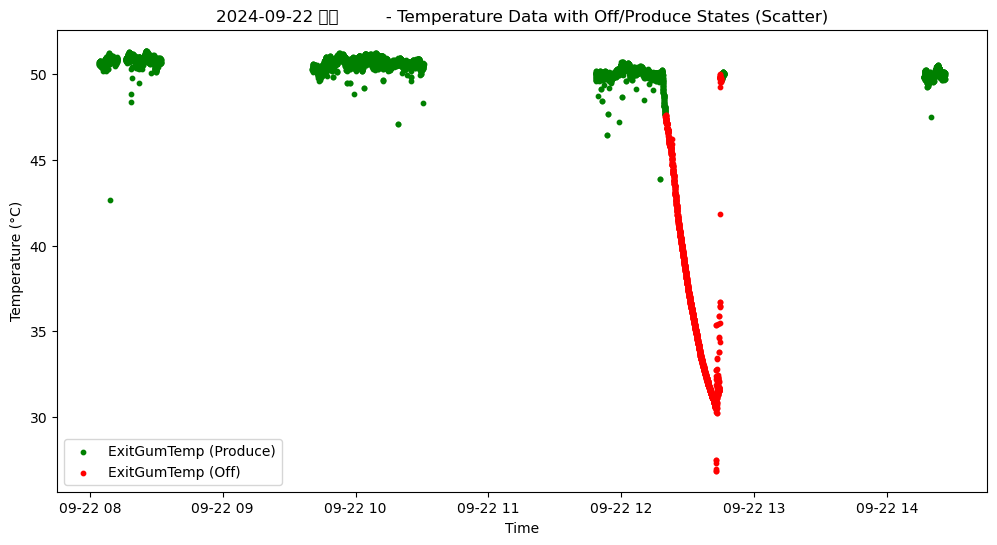

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


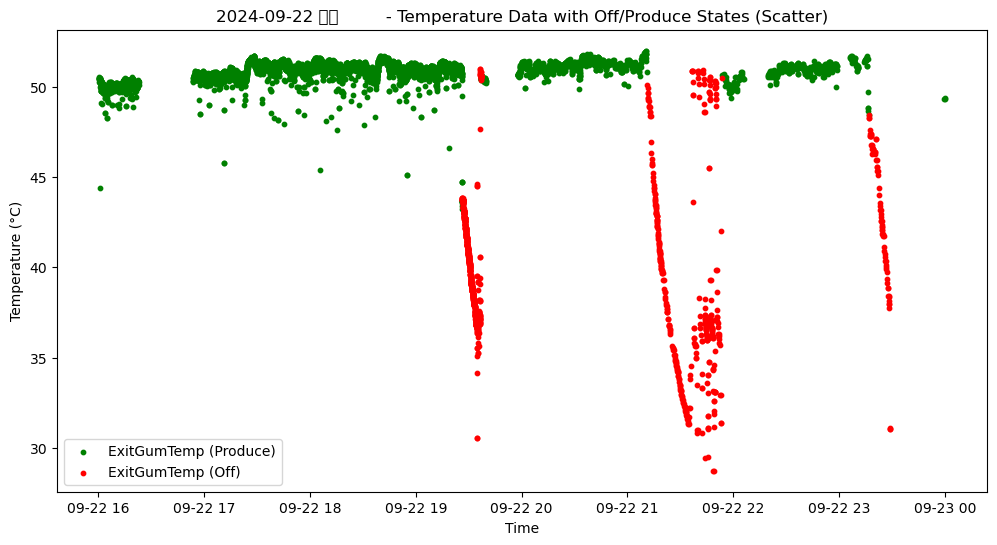

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


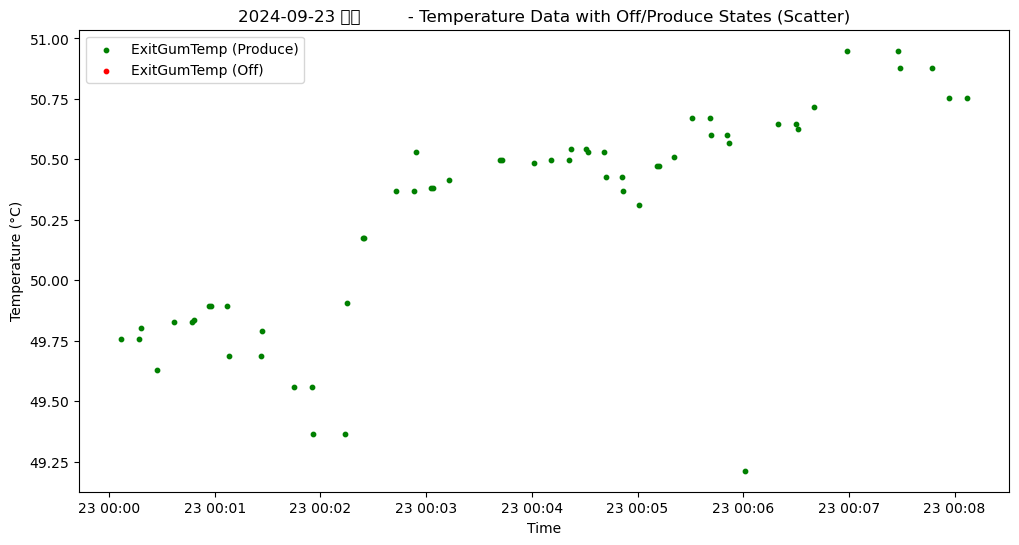

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


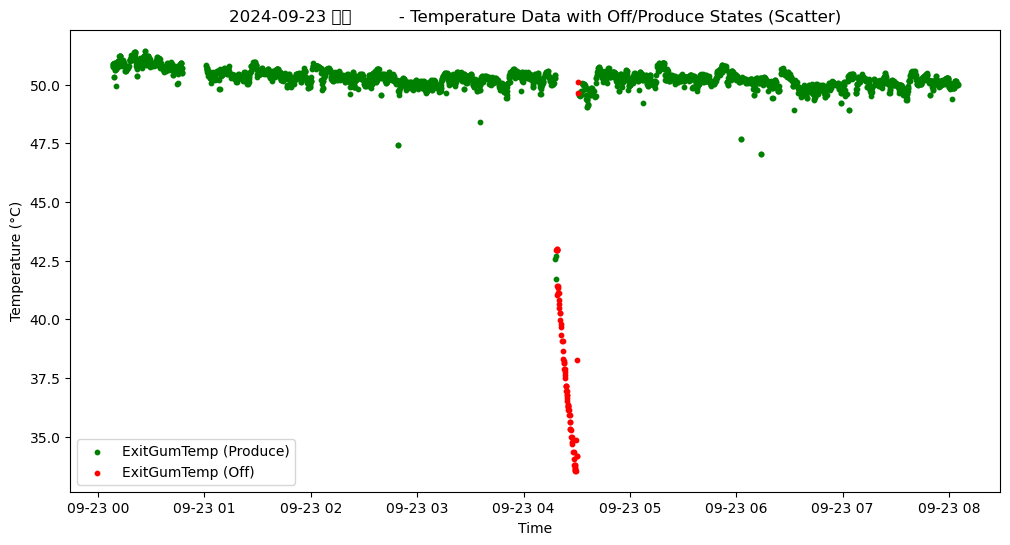

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


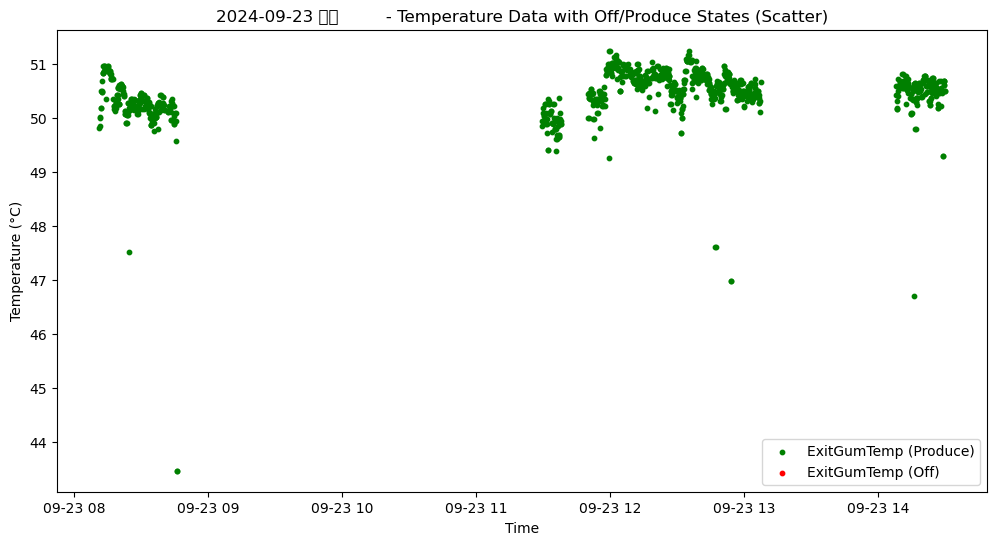

In [91]:
# 将没有数据的时间展现出来
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Apply the is_producing function to determine the offperiod
EXCW_df['offperiod'] = EXCW_df.apply(is_producing, axis=1)

# 确保 'Day_shift' 列是日期时间格式
# EXCW_df['Day_shift'] = pd.to_datetime(EXCW_df['Day_shift'])

# 获取所有唯一的日期
all_dates = EXCW_df['Day_shift'].unique()

# 定义时间间隔阈值（0.5小时）
time_threshold = pd.Timedelta(hours=0.5)

# 遍历每个日期
for Day_shift in all_dates:
    # 筛选出当前日期的数据
    filtered_data = EXCW_df[EXCW_df['Day_shift'] == Day_shift].copy()
    
    # 计算相邻数据点之间的时间差
    filtered_data['time_diff'] = filtered_data['DataTime'].diff()

    # 对于时间差大于1小时的行，将对应的温度列替换为 NaN，使图表线断开
    mask = filtered_data['time_diff'] > time_threshold
    filtered_data.loc[mask, ['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp']] = np.nan

    # 分开 "produce" 和 "off" 数据
    produce_data = filtered_data[filtered_data['offperiod'] == 'produce']
    off_data = filtered_data[filtered_data['offperiod'] == 'off']
    
    # 绘制图表
    plt.figure(figsize=(12, 6))
    
    # 绘制 "produce" 状态的散点图（绿色）
    plt.scatter(produce_data['DataTime'], produce_data['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'], color="green", label="ExitGumTemp (Produce)", s=10)
    
    # 绘制 "off" 状态的散点图（红色）
    plt.scatter(off_data['DataTime'], off_data['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'], color="red", label="ExitGumTemp (Off)", s=10)
    
    # 设置标题、标签和图例
    plt.title(f"{Day_shift} - Temperature Data with Off/Produce States (Scatter)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    
    # 显示图表
    plt.show()

In [92]:
EXCW_df_produce_duration_final = produce_EXCW_df.sort_values(by=['produce_duration_min'],ascending =False)
EXCW_df_produce_duration_final

,start_DataTime,end_DataTime,produce_duration,sugar,item,Day_shift,produce_duration_min
44,2024-09-23 04:31:02,2024-09-23 08:05:06,0 days 03:34:04,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-23 晚班,214.066667
2,2024-08-26 21:15:43,2024-08-26 23:19:34,0 days 02:03:51,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,123.850000
0,2024-08-26 16:04:01,2024-08-26 17:58:04,0 days 01:54:03,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,114.050000
9,2024-08-26 11:33:34,2024-08-26 13:27:08,0 days 01:53:34,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 早班,113.566667
16,2024-09-12 08:03:31,2024-09-12 09:43:29,0 days 01:39:58,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-12 早班,99.966667
1,2024-08-26 18:08:29,2024-08-26 19:39:58,0 days 01:31:29,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,91.483333
26,2024-09-12 03:00:18,2024-09-12 03:58:45,0 days 00:58:27,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-12 晚班,58.450000
13,2024-08-27 07:28:13,2024-08-27 08:24:36,0 days 00:56:23,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-27 晚班,56.383333
25,2024-09-12 02:02:16,2024-09-12 02:55:26,0 days 00:53:10,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-12 晚班,53.166667
28,2024-09-12 04:19:21,2024-09-12 05:12:24,0 days 00:53:03,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-12 晚班,53.050000


In [93]:
EXCW_df_produce_duration_final2 = EXCW_df_produce_duration_final[EXCW_df_produce_duration_final['produce_duration_min'] > 1]
EXCW_df_produce_duration_final3 = EXCW_df_produce_duration_final2.groupby(['sugar','item','Day_shift'])['produce_duration_min'].mean().reset_index().sort_values(by=['produce_duration_min'],ascending = False)

EXCW_df_top5_shift_list= EXCW_df_produce_duration_final3['Day_shift'].head(5).tolist()
print(EXCW_df_top5_shift_list)
EXCW_df_produce_duration_final3

['2024-09-23 晚班        ', '2024-08-26 中班        ', '2024-08-26 早班        ', '2024-09-12 晚班        ', '2024-09-12 早班        ']


,sugar,item,Day_shift,produce_duration_min
9,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-23 晚班,214.066667
0,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 中班,87.979167
1,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-26 早班,35.741667
5,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-12 晚班,29.129630
4,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-12 早班,28.159524
3,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-27 晚班,23.455556
7,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-22 晚班,14.616667
2,Sugarfree,EXCW（益达西瓜-NCS）,2024-08-27 中班,14.483333
6,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-13 晚班,13.472222
8,Sugarfree,EXCW（益达西瓜-NCS）,2024-09-23 中班,8.000000


In [94]:
#把这最稳定的5个班次的所有挤压机出口温度从低到高排列。我们找到20% percentile和80% percentile。我们认为，生成最稳的天数中，温度比较中间的区域，是较好的温度
# 使用 isin() 筛选 'Day' 列的值是否在 sugar_top_list 中
EXCW_produce_join_df = EXCW_df[(EXCW_df['offperiod'] == 'produce') & (EXCW_df['Day_shift'].isin(EXCW_df_top5_shift_list))]

# 获取挤压机出口温度列
EXCW_temperatures = EXCW_produce_join_df['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'].sort_values()
EXCW_temperatures

1067630    40.011574
1067620    40.277780
1087297    40.277780
1087298    40.277780
189954     40.393520
             ...    
1103536    53.090280
1103622    53.090280
1103616    53.101850
1103362    53.136574
1103361    53.171295
Name: CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp, Length: 63643, dtype: float64

C:\Users\Admin\AppData\Local\Temp\ipykernel_1168\409728417.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(EXCW_temperatures, shade=True)


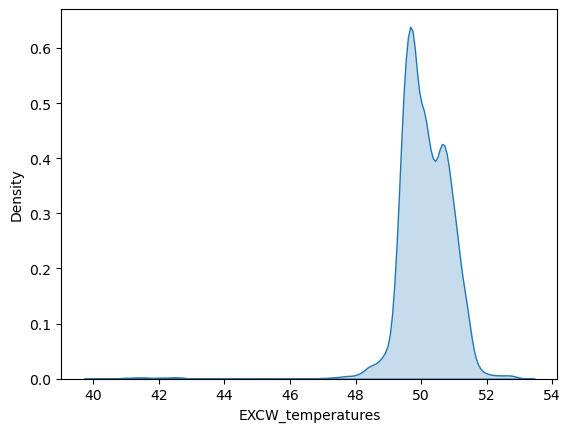

count    63643.000000
mean        50.106650
std          0.907588
min         40.011574
25%         49.641205
50%         50.081020
75%         50.659720
max         53.171295
Name: CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp, dtype: float64


In [95]:
# 绘制密度图
sns.kdeplot(EXCW_temperatures, shade=True)
# 添加标题和标签
plt.xlabel('EXCW_temperatures')
plt.ylabel('Density')
# 显示图形
plt.show()

print(EXCW_temperatures.describe())

In [96]:
# 对温度进行排序
sorted_temperatures = EXCW_temperatures.sort_values()

# 计算 20% 和 80% 分位数
percentile_20 = sorted_temperatures.quantile(0.2)
percentile_80 = sorted_temperatures.quantile(0.8)

# 显示结果
print(f"20th percentile: {percentile_20}")
print(f"80th percentile: {percentile_80}")

# 计算 10% 和 90% 分位数
percentile_10 = sorted_temperatures.quantile(0.1)
percentile_90 = sorted_temperatures.quantile(0.9)

# 显示结果
print(f"10th percentile: {percentile_10}")
print(f"90th percentile: {percentile_90}")

# 计算 5% 和 95% 分位数
percentile_5 = sorted_temperatures.quantile(0.05)
percentile_95 = sorted_temperatures.quantile(0.95)

# 显示结果
print(f"5th percentile: {percentile_5}")
print(f"95th percentile: {percentile_95}")

20th percentile: 49.560184
80th percentile: 50.77546
10th percentile: 49.363426
90th percentile: 51.064816
5th percentile: 49.17824
95th percentile: 51.28472


### 1.4 查看EBB（益达蓝莓-NCS）香型的threshold

In [97]:
produce_EBB_df

,start_DataTime,end_DataTime,produce_duration,sugar,item,Day_shift,produce_duration_min
0,2024-08-28 17:46:32,2024-08-28 18:06:55,0 days 00:20:23,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-28 中班,20.383333
1,2024-08-28 18:15:10,2024-08-28 19:31:42,0 days 01:16:32,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-28 中班,76.533333
2,2024-08-28 19:39:55,2024-08-28 19:50:29,0 days 00:10:34,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-28 中班,10.566667
3,2024-08-28 23:22:39,2024-08-28 23:34:05,0 days 00:11:26,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-28 中班,11.433333
4,2024-08-28 23:38:37,2024-08-28 23:42:12,0 days 00:03:35,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-28 中班,3.583333
5,2024-08-29 05:05:55,2024-08-29 05:12:22,0 days 00:06:27,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-29 晚班,6.450000
6,2024-09-14 16:00:19,2024-09-14 16:03:43,0 days 00:03:24,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 中班,3.400000
7,2024-09-14 16:03:45,2024-09-14 16:03:47,0 days 00:00:02,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 中班,0.033333
8,2024-09-14 16:28:35,2024-09-14 19:50:15,0 days 03:21:40,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 中班,201.666667
9,2024-09-14 20:12:46,2024-09-14 23:05:21,0 days 02:52:35,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 中班,172.583333


C:\Users\Admin\AppData\Local\Temp\ipykernel_1168\3093274654.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EBB_df['offperiod'] = EBB_df.apply(is_producing, axis=1)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


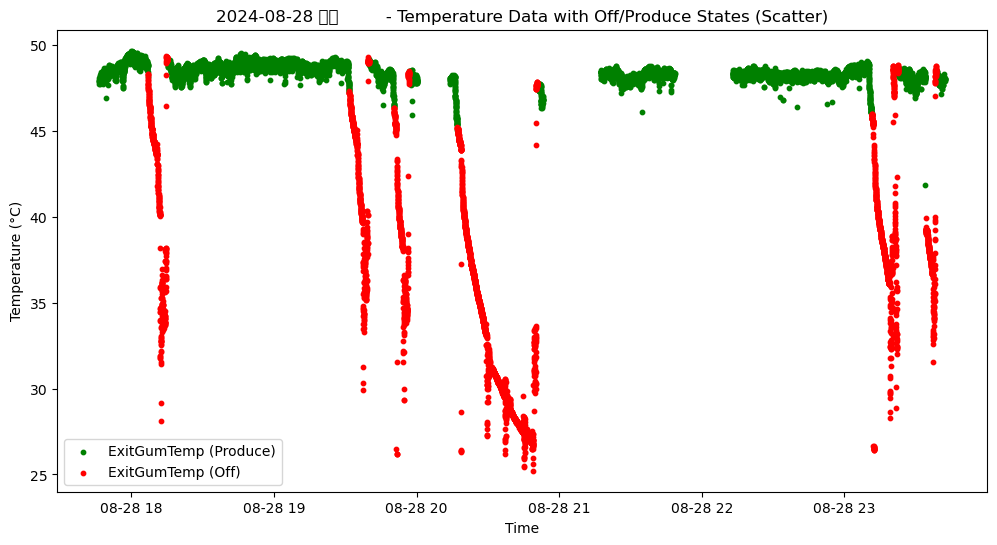

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


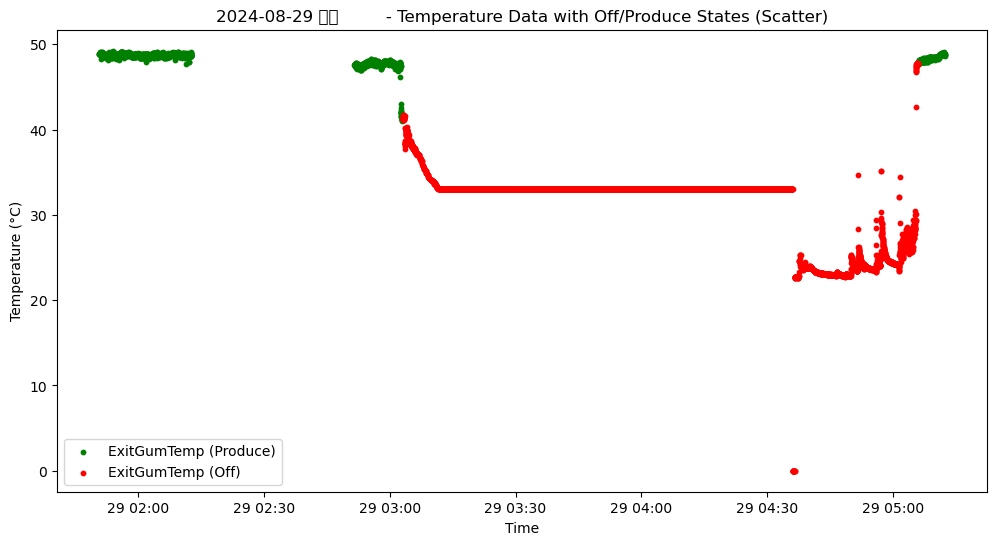

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


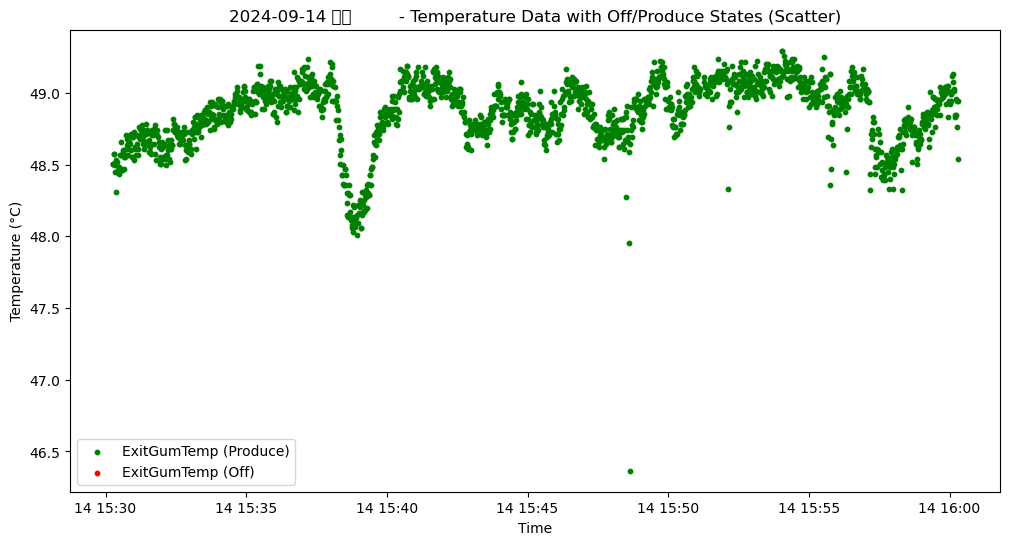

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


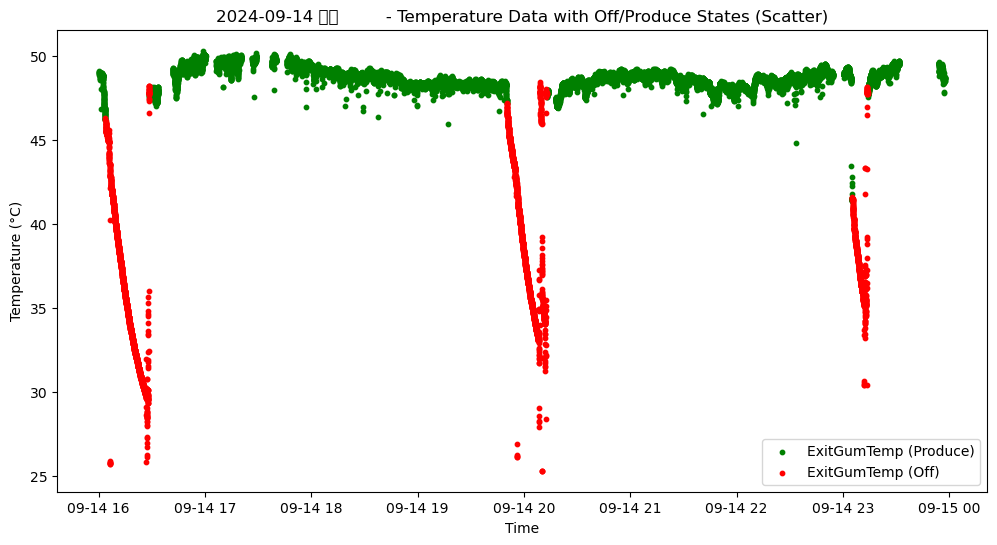

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


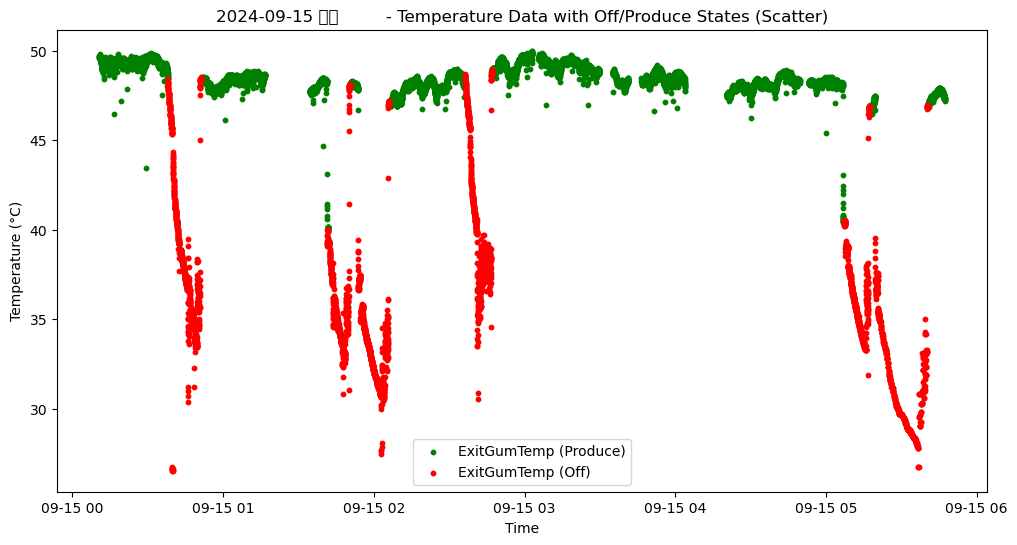

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


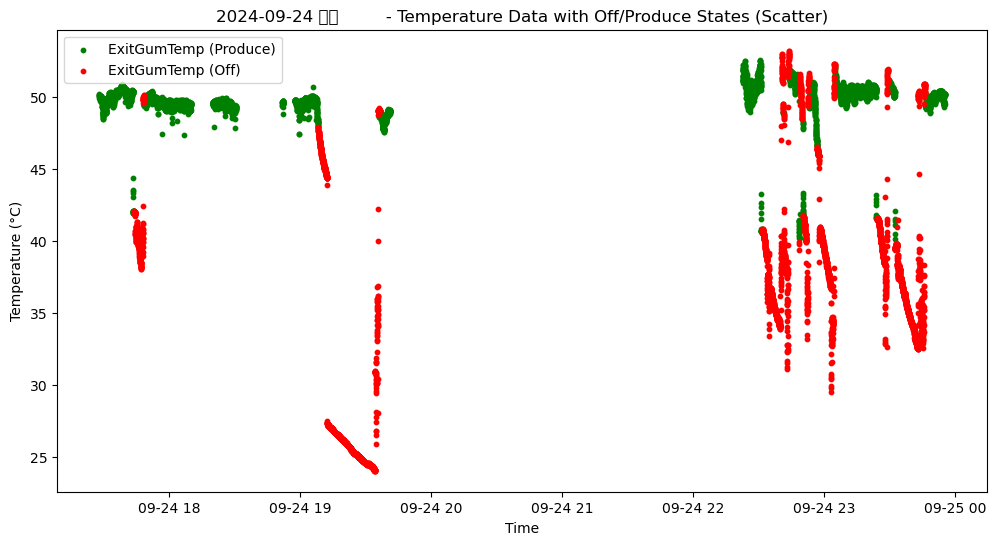

d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26202 (\N{CJK UNIFIED IDEOGRAPH-665A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


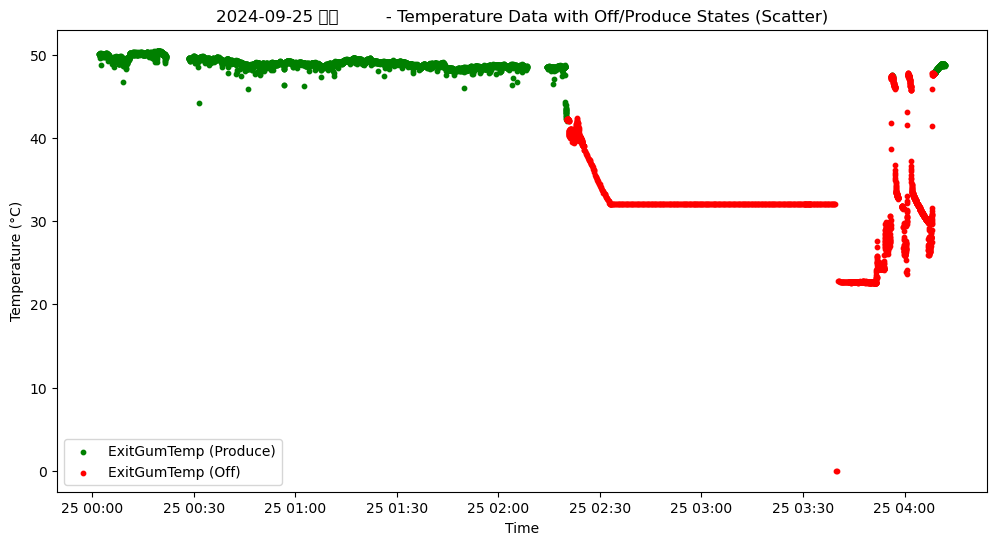

In [98]:
# 将没有数据的时间展现出来
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Apply the is_producing function to determine the offperiod
EBB_df['offperiod'] = EBB_df.apply(is_producing, axis=1)

# 确保 'Day_shift' 列是日期时间格式
# EBB_df['Day_shift'] = pd.to_datetime(EBB_df['Day_shift'])

# 获取所有唯一的日期
all_dates = EBB_df['Day_shift'].unique()

# 定义时间间隔阈值（0.5小时）
time_threshold = pd.Timedelta(hours=0.5)

# 遍历每个日期
for Day_shift in all_dates:
    # 筛选出当前日期的数据
    filtered_data = EBB_df[EBB_df['Day_shift'] == Day_shift].copy()
    
    # 计算相邻数据点之间的时间差
    filtered_data['time_diff'] = filtered_data['DataTime'].diff()

    # 对于时间差大于1小时的行，将对应的温度列替换为 NaN，使图表线断开
    mask = filtered_data['time_diff'] > time_threshold
    filtered_data.loc[mask, ['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp']] = np.nan

    # 分开 "produce" 和 "off" 数据
    produce_data = filtered_data[filtered_data['offperiod'] == 'produce']
    off_data = filtered_data[filtered_data['offperiod'] == 'off']
    
    # 绘制图表
    plt.figure(figsize=(12, 6))
    
    # 绘制 "produce" 状态的散点图（绿色）
    plt.scatter(produce_data['DataTime'], produce_data['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'], color="green", label="ExitGumTemp (Produce)", s=10)
    
    # 绘制 "off" 状态的散点图（红色）
    plt.scatter(off_data['DataTime'], off_data['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'], color="red", label="ExitGumTemp (Off)", s=10)
    
    # 设置标题、标签和图例
    plt.title(f"{Day_shift} - Temperature Data with Off/Produce States (Scatter)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    
    # 显示图表
    plt.show()

In [99]:
EBB_df_produce_duration_final = produce_EBB_df.sort_values(by=['produce_duration_min'],ascending =False)
EBB_df_produce_duration_final

,start_DataTime,end_DataTime,produce_duration,sugar,item,Day_shift,produce_duration_min
8,2024-09-14 16:28:35,2024-09-14 19:50:15,0 days 03:21:40,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 中班,201.666667
9,2024-09-14 20:12:46,2024-09-14 23:05:21,0 days 02:52:35,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 中班,172.583333
29,2024-09-25 00:02:06,2024-09-25 02:20:17,0 days 02:18:11,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-25 晚班,138.183333
1,2024-08-28 18:15:10,2024-08-28 19:31:42,0 days 01:16:32,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-28 中班,76.533333
16,2024-09-15 02:06:14,2024-09-15 02:36:22,0 days 00:30:08,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-15 晚班,30.133333
10,2024-09-14 15:30:15,2024-09-14 16:00:18,0 days 00:30:03,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 早班,30.050000
11,2024-09-15 00:10:44,2024-09-15 00:37:59,0 days 00:27:15,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-15 晚班,27.250000
0,2024-08-28 17:46:32,2024-08-28 18:06:55,0 days 00:20:23,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-28 中班,20.383333
26,2024-09-24 23:04:53,2024-09-24 23:24:22,0 days 00:19:29,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-24 中班,19.483333
19,2024-09-24 17:28:02,2024-09-24 17:43:58,0 days 00:15:56,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-24 中班,15.933333


In [100]:
EBB_df_produce_duration_final2 = EBB_df_produce_duration_final[EBB_df_produce_duration_final['produce_duration_min'] > 1]
EBB_df_produce_duration_final3 = EBB_df_produce_duration_final2.groupby(['sugar','item','Day_shift'])['produce_duration_min'].mean().reset_index().sort_values(by=['produce_duration_min'],ascending = False)

EBB_df_top5_shift_list= EBB_df_produce_duration_final3['Day_shift'].head(5).tolist()
print(EBB_df_top5_shift_list)
EBB_df_produce_duration_final3

['2024-09-14 中班        ', '2024-09-25 晚班        ', '2024-09-14 早班        ', '2024-08-28 中班        ', '2024-09-15 晚班        ']


,sugar,item,Day_shift,produce_duration_min
2,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 中班,125.883333
6,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-25 晚班,70.700000
3,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-14 早班,30.050000
0,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-28 中班,24.500000
4,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-15 晚班,13.896667
5,Sugarfree,EBB（益达蓝莓-NCS）,2024-09-24 中班,9.313889
1,Sugarfree,EBB（益达蓝莓-NCS）,2024-08-29 晚班,6.450000


In [101]:
# 使用 isin() 筛选 'Day' 列的值是否在 sugar_top_list 中
EBB_produce_join_df = EBB_df[(EBB_df['offperiod'] == 'produce') & (EBB_df['Day_shift'].isin(EBB_df_top5_shift_list))]

# 获取挤压机出口温度列
EBB_temperatures = EBB_produce_join_df['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'].sort_values()
EBB_temperatures

1287375    40.011574
1287368    40.034720
1287371    40.069447
1287367    40.092590
1287372    40.104164
             ...    
1866082    50.428240
1866092    50.439816
1866124    50.451390
1866083    50.462960
1866089    50.474540
Name: CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp, Length: 56282, dtype: float64

C:\Users\Admin\AppData\Local\Temp\ipykernel_1168\2868169066.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(EBB_temperatures, shade=True)


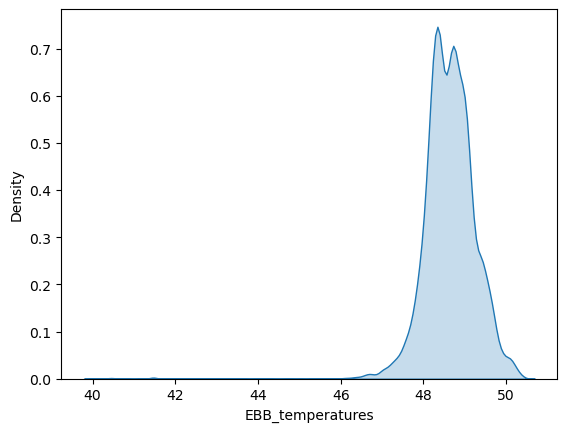

count    56282.000000
mean        48.626218
std          0.654284
min         40.011574
25%         48.275460
50%         48.634260
75%         49.004630
max         50.474540
Name: CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp, dtype: float64


In [102]:
# 绘制密度图
sns.kdeplot(EBB_temperatures, shade=True)
# 添加标题和标签
plt.xlabel('EBB_temperatures')
plt.ylabel('Density')
# 显示图形
plt.show()

print(EBB_temperatures.describe())

In [103]:
# 对温度进行排序
sorted_temperatures = EBB_temperatures.sort_values()

# 计算 20% 和 80% 分位数
percentile_20 = sorted_temperatures.quantile(0.2)
percentile_80 = sorted_temperatures.quantile(0.8)

# 显示结果
print(f"20th percentile: {percentile_20}")
print(f"80th percentile: {percentile_80}")

# 计算 10% 和 90% 分位数
percentile_10 = sorted_temperatures.quantile(0.1)
percentile_90 = sorted_temperatures.quantile(0.9)

# 显示结果
print(f"10th percentile: {percentile_10}")
print(f"90th percentile: {percentile_90}")

# 计算 5% 和 95% 分位数
percentile_5 = sorted_temperatures.quantile(0.05)
percentile_95 = sorted_temperatures.quantile(0.95)

# 显示结果
print(f"5th percentile: {percentile_5}")
print(f"95th percentile: {percentile_95}")

20th percentile: 48.20602
80th percentile: 49.08565
10th percentile: 47.98611
90th percentile: 49.386574
5th percentile: 47.743053
95th percentile: 49.60648
